# Cas usage numéro 2 

In [1]:
# commande pour le téléchargement des packages utiles pour ce TD
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install statsmodels
%pip install geopy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### Liste des librairies utilisées pour réaliser l'analyse :
***

In [3]:
# import des fonctionalités des packages
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np 
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from scipy import signal
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import os
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import CategoricalNB
import scipy.stats
sns.set_theme()


### Partie 1. La fréquentation<a id='p0'></a>

In [4]:
# importer le fichier des fréquentations journalières 2022-2023
data = pd.read_excel('Donnees intiales/frequentation_journaliere_2022-2023.xlsx')

# dimensions du jeu de données
nombre_lignes, nombre_colonnes = data.shape
print("Nombre de lignes:", nombre_lignes)
print("Nombre de colonnes:", nombre_colonnes)

# visualiser les 5 premières lignes du dataframe
data.head(5)

Nombre de lignes: 4380
Nombre de colonnes: 5


,Nom de la gare,UIC,DRG,Date,Fréquentation gare
0,Angers Saint-Laud,87484006,DRG B-CVL-PDL,2023-12-31,16754
1,Guingamp,87473207,DRG B-CVL-PDL,2023-12-31,2274
2,Nantes,87481002,DRG B-CVL-PDL,2023-12-31,34282
3,Rennes,87471003,DRG B-CVL-PDL,2023-12-31,37472
4,Saint-Brieuc,87473009,DRG B-CVL-PDL,2023-12-31,2167


In [5]:
# Remplacer les espaces par des _ dans les noms de colonnes (faciliter l'appel des colonnes)
data.columns = data.columns.str.replace(' ', '_')

# Suppression des _ en trop (au début et à la fin)
for clef in data.columns:
    if clef[-1] == "_":  # Vérification si le dernier caractère est un _
        new_column_name = clef[:-1]  # Nouveau nom de colonne sans le dernier caractère
        data.rename(columns={clef: new_column_name}, inplace=True)
    if clef[0] == "_":  # Vérification si le premier caractère est un _
        new_column_name = clef[1:]  # Nouveau nom de colonne sans le premier caractère
        data.rename(columns={clef: new_column_name}, inplace=True)
        
# Recoder les noms de gare mal orthographié
data['Nom_de_la_gare'] = data['Nom_de_la_gare'].replace({'Angers Saint-Laud' : 'Angers'})
        
data.head(5)

,Nom_de_la_gare,UIC,DRG,Date,Fréquentation_gare
0,Angers,87484006,DRG B-CVL-PDL,2023-12-31,16754
1,Guingamp,87473207,DRG B-CVL-PDL,2023-12-31,2274
2,Nantes,87481002,DRG B-CVL-PDL,2023-12-31,34282
3,Rennes,87471003,DRG B-CVL-PDL,2023-12-31,37472
4,Saint-Brieuc,87473009,DRG B-CVL-PDL,2023-12-31,2167


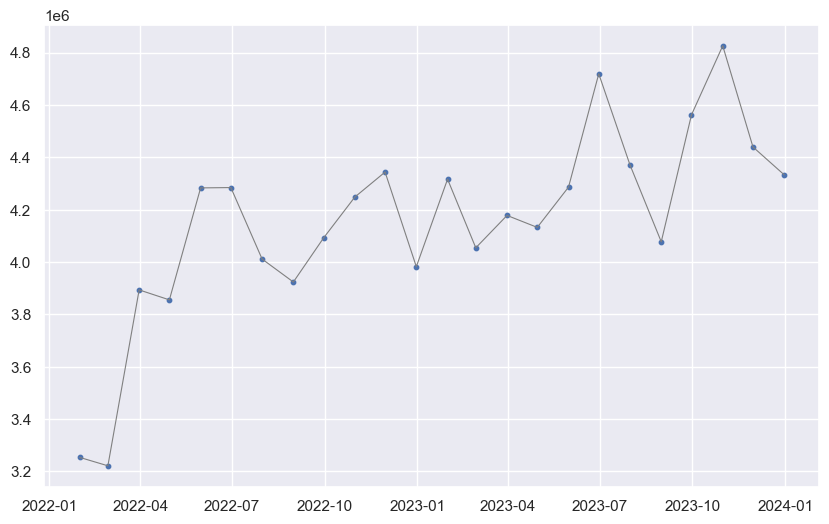

In [6]:
# Série temporelle de l'affluence générale
data2 = data[['Fréquentation_gare', 'Date']]
data2 = data2.set_index('Date')
data2 = data2.resample('M').sum()
ts = pd.Series(data2['Fréquentation_gare'])

plt.figure(figsize=(10, 6))
plt.plot(data2.index, ts, color = 'gray', linewidth = 0.8)
plt.scatter(data2.index, ts, marker = 'o', s = 10)

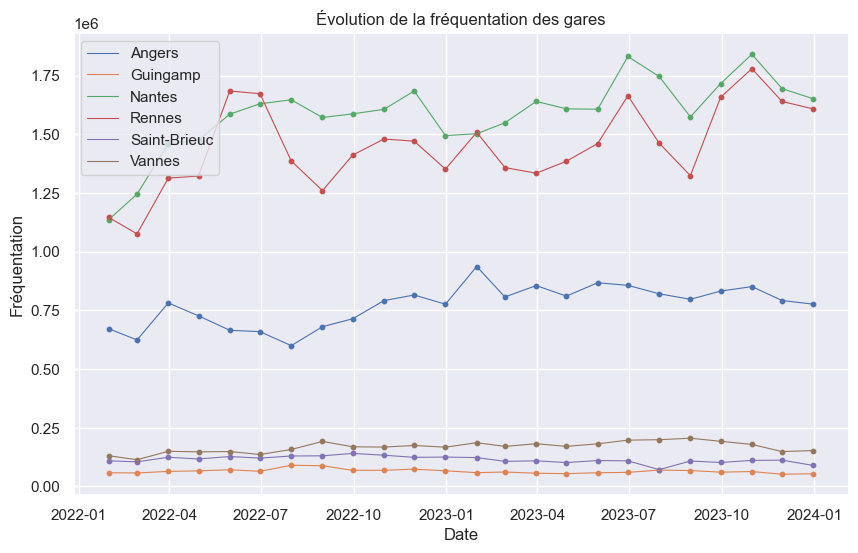

In [7]:
# Séries temporelle par Gare
series_temp = data[['Date', 'Fréquentation_gare', 'Nom_de_la_gare']]

ts = series_temp['Fréquentation_gare']

# Créer une table pivot
series_temp = series_temp.pivot_table(index='Date', 
                                      columns='Nom_de_la_gare', 
                                      values='Fréquentation_gare', 
                                      aggfunc='sum')

# Rééchantillonner par mois
series_temp_mois = series_temp.resample('M').sum()

# Plot
plt.figure(figsize=(10, 6))

# Plot chaque gare séparément
for gare_name in series_temp_mois.columns:
    plt.plot(series_temp_mois.index, 
             series_temp_mois[gare_name], 
             label=gare_name, 
             linewidth=0.8)
    plt.scatter(series_temp_mois.index, 
                series_temp_mois[gare_name], 
                marker='o', 
                s=10)

# Ajouter des légendes et des titres
plt.legend()
plt.title('Évolution de la fréquentation des gares')
plt.xlabel('Date')
plt.ylabel('Fréquentation')
plt.show()

In [8]:
series_temp.to_csv('Donnees finales/frequentation.csv')

# Ajout du jour de la semaine
# Import du fichier extrait plus haut (pour avoir la colonne date)
series_temp = pd.read_csv('Donnees finales/frequentation.csv', sep=',',encoding='utf-8')

# Convertir la colonne Date en format Date
series_temp['Date'] = pd.to_datetime(series_temp['Date'], errors='coerce')

# récupération du jour de la semaine : 0 pour lundi 6 pour dimanche
series_temp['jour_semaine'] = series_temp['Date'].dt.day_of_week 

series_temp.to_csv('Donnees finales/frequentation.csv')

In [9]:
# importer le fichier des capteurs actifs par jour en 2022-2023
capteurs = pd.read_excel('Donnees intiales/nombre_capteurs_actif_par_jour_2022-2023.xlsx')
capteurs['Site_Name'].unique()

array(['Rennes', 'Saint-Brieuc', 'Guimgamp', 'Vannes', 'Nantes',
       'Angers-St-Laud'], dtype=object)

In [10]:
# Recoder les noms de gare mal orthographié
capteurs['Site_Name'] = capteurs['Site_Name'].replace({'Angers-St-Laud' : 'Angers', 'Guimgamp' : 'Guingamp'})
capteurs['Site_Name'].unique()

array(['Rennes', 'Saint-Brieuc', 'Guingamp', 'Vannes', 'Nantes', 'Angers'],
      dtype=object)

In [11]:
# Ajout du nombre de capteurs actifs
data_capteurs = pd.merge(data, capteurs, 
                left_on = ['UIC', 'Date'], 
                right_on = ['UIC', 'date'])

# dimensions du jeu de données
nombre_lignes, nombre_colonnes = data_capteurs.shape
print("Nombre de lignes:", nombre_lignes)
print("Nombre de colonnes:", nombre_colonnes)

data_capteurs.head(5)

Nombre de lignes: 4380
Nombre de colonnes: 8


,Nom_de_la_gare,UIC,DRG,Date,Fréquentation_gare,date,Site_Name,Nombre de capteurs actif(s)
0,Angers,87484006,DRG B-CVL-PDL,2023-12-31,16754,2023-12-31,Angers,5
1,Guingamp,87473207,DRG B-CVL-PDL,2023-12-31,2274,2023-12-31,Guingamp,1
2,Nantes,87481002,DRG B-CVL-PDL,2023-12-31,34282,2023-12-31,Nantes,19
3,Rennes,87471003,DRG B-CVL-PDL,2023-12-31,37472,2023-12-31,Rennes,15
4,Saint-Brieuc,87473009,DRG B-CVL-PDL,2023-12-31,2167,2023-12-31,Saint-Brieuc,3


In [12]:
# Enlever les lignes où les capteurs ne sont pas actifs
data_capteurs2 = data_capteurs[data_capteurs['Nombre de capteurs actif(s)'] > 0]

# dimensions du jeu de données
nombre_lignes2, nombre_colonnes2 = data_capteurs2.shape
print("Nombre de lignes:", nombre_lignes2)
print("Nombre de colonnes:", nombre_colonnes2)
print("Nombre de lignes supprimées :", nombre_lignes - nombre_lignes2)

data_capteurs2.head(5)

Nombre de lignes: 4359
Nombre de colonnes: 8
Nombre de lignes supprimées : 21


,Nom_de_la_gare,UIC,DRG,Date,Fréquentation_gare,date,Site_Name,Nombre de capteurs actif(s)
0,Angers,87484006,DRG B-CVL-PDL,2023-12-31,16754,2023-12-31,Angers,5
1,Guingamp,87473207,DRG B-CVL-PDL,2023-12-31,2274,2023-12-31,Guingamp,1
2,Nantes,87481002,DRG B-CVL-PDL,2023-12-31,34282,2023-12-31,Nantes,19
3,Rennes,87471003,DRG B-CVL-PDL,2023-12-31,37472,2023-12-31,Rennes,15
4,Saint-Brieuc,87473009,DRG B-CVL-PDL,2023-12-31,2167,2023-12-31,Saint-Brieuc,3


In [13]:
# Suppression des données avec un fonctionnement des capteurs inférieur à 50%

# on ne garde que les colonnes de la date, du nom de la gare et du nombre de capteurs
max_capteurs =  data_capteurs2[['Date', 'Nom_de_la_gare', 'Nombre de capteurs actif(s)']]

# récupération du max
max_capteurs =  max_capteurs.groupby(['Nom_de_la_gare'], as_index=False)['Nombre de capteurs actif(s)'].max() 

# renommage de la colonne du nombre de capteurs
max_capteurs.rename(columns={'Nombre de capteurs actif(s)' : 'Max_capteurs'}, inplace=True)

# ajout d'une colonne avec le nombre de capteurs max
data_capteurs2 = pd.merge(data_capteurs2, max_capteurs, left_on = ['Nom_de_la_gare'], right_on = ['Nom_de_la_gare'])

# seuil de 50%
seuil = .5

# max_capteurs

# Enlever les lignes où les capteurs ne sont pas actifs
data_capteurs3 = data_capteurs2[data_capteurs2['Nombre de capteurs actif(s)'] > (data_capteurs2['Max_capteurs']*seuil)]

# dimensions du jeu de données
nombre_lignes3, nombre_colonnes3 = data_capteurs3.shape
print("Nombre de lignes:", nombre_lignes3)
print("Nombre de colonnes:", nombre_colonnes3)
print("Nombre de lignes supprimées :", nombre_lignes - nombre_lignes2)

data_capteurs2.head(5)

Nombre de lignes: 4352
Nombre de colonnes: 9
Nombre de lignes supprimées : 21


,Nom_de_la_gare,UIC,DRG,Date,Fréquentation_gare,date,Site_Name,Nombre de capteurs actif(s),Max_capteurs
0,Angers,87484006,DRG B-CVL-PDL,2023-12-31,16754,2023-12-31,Angers,5,5
1,Angers,87484006,DRG B-CVL-PDL,2023-12-30,19781,2023-12-30,Angers,5,5
2,Angers,87484006,DRG B-CVL-PDL,2023-12-29,22976,2023-12-29,Angers,5,5
3,Angers,87484006,DRG B-CVL-PDL,2023-12-28,22083,2023-12-28,Angers,5,5
4,Angers,87484006,DRG B-CVL-PDL,2023-12-27,23190,2023-12-27,Angers,5,5


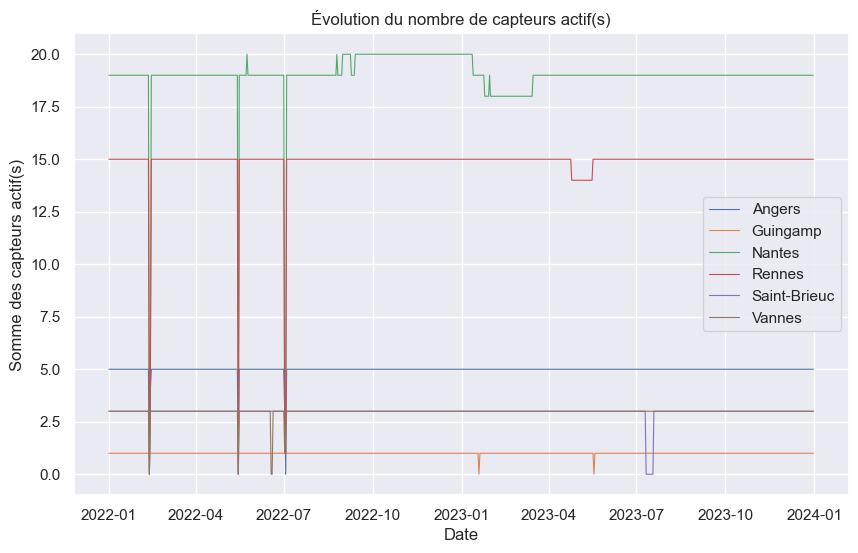

In [14]:
# Séries temporelle par Gare
series_temp_capteurs = data_capteurs[['Date', 'Nombre de capteurs actif(s)', 'Nom_de_la_gare']]

ts = series_temp_capteurs['Nombre de capteurs actif(s)']

# Créer une table pivot
series_temp_capteurs = series_temp_capteurs.pivot_table(index='Date', 
                                      columns='Nom_de_la_gare', 
                                      values='Nombre de capteurs actif(s)', 
                                      aggfunc='sum')

# Plot
plt.figure(figsize=(10, 6))

# Plot chaque gare séparément
for gare_name in series_temp_capteurs.columns:
    plt.plot(series_temp_capteurs.index, 
             series_temp_capteurs[gare_name], 
             label=gare_name, 
             linewidth=0.8)

# Ajouter des légendes et des titres
plt.legend()
plt.title('Évolution du nombre de capteurs actif(s)')
plt.xlabel('Date')
plt.ylabel('Somme des capteurs actif(s)')
plt.show()

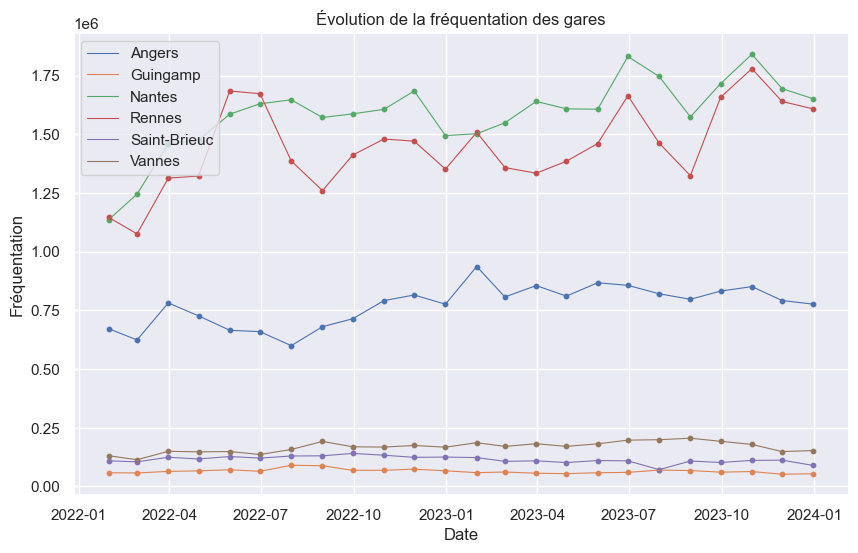

In [15]:
# Série temporelle des capteurs par mois
series_temp_capteurs2 = data_capteurs2[['Date', 'Fréquentation_gare', 'Nom_de_la_gare']]

ts = series_temp_capteurs2['Fréquentation_gare']

# Créer une table pivot
series_temp_capteurs2 = series_temp_capteurs2.pivot_table(index='Date', 
                                      columns='Nom_de_la_gare', 
                                      values='Fréquentation_gare', 
                                      aggfunc='sum')

# Rééchantillonner par mois
series_temp_capteurs_mois2 = series_temp_capteurs2.resample('M').sum()

# Plot
plt.figure(figsize=(10, 6))

# Plot chaque gare séparément
for gare_name in series_temp_capteurs2.columns:
    plt.plot(series_temp_capteurs_mois2.index, 
             series_temp_capteurs_mois2[gare_name], 
             label=gare_name, 
             linewidth=0.8)
    plt.scatter(series_temp_capteurs_mois2.index, 
                series_temp_capteurs_mois2[gare_name], 
                marker='o', 
                s=10)

# Ajouter des légendes et des titres
plt.legend()
plt.title('Évolution de la fréquentation des gares')
plt.xlabel('Date')
plt.ylabel('Fréquentation')
plt.show()

In [16]:
series_temp_capteurs.to_csv('Donnees finales/capteurs.csv')

### Partie 2. Codage pour les pays de la Loire<a id='p0'></a>

In [17]:
# importer le fichier dans un objet python dataframe, nommé "data" pour l'exemple
agenda_evenements_PDL = pd.read_csv('evenements/agenda-culture-de-la-region-des-pays-de-la-loire@paysdelaloire.csv',
                                    sep=';',encoding='utf-8')

In [18]:
agenda_evenements_PDL.head(10)

,Identifiant,Slug,URL canonique,Titre,Description,Description longue,Détail des conditions,Mots clés,Image,Crédits image,...,Nom du pays,Registration,Liens additionnels,firstdate,firsttimestart,firsttimeend,lastdate,lasttimestart,lasttimeend,statut
0,49257337,decibel-gavy,https://openagenda.com/pays-de-la-loire-cultur...,DECIBEL GAVY,dans le cadre du Festival Culture Bar-Bars,"<p>Club de musique de l’école Polytech Nantes,...",NaN,pop;rock,https://cibul.s3.amazonaws.com/8122730edea74e9...,NaN,...,France (Métropole),NaN,"[{""data"": {""author"": ""D\u00e9cibelGavy"", ""cach...",2023-11-25,20:00,22:00,2023-11-25,20:00,22:00,Evenement passé
1,61295898,les-tremplins-du-tempo,https://openagenda.com/pays-de-la-loire-cultur...,LES TREMPLINS DU TEMPO,dans le cadre du Festival Culture Bar-Bars,NaN,NaN,tremplins,https://cibul.s3.amazonaws.com/a20507aab674497...,NaN,...,France (Métropole),NaN,NaN,2023-11-25,20:00,22:00,2023-11-25,20:00,22:00,Evenement passé
2,32900623,croche-dedans-4580792,https://openagenda.com/pays-de-la-loire-cultur...,CROCHE DEDANS,dans le cadre du Festival Culture Bar-Bars,<p>Croche dedans ça donne envie de boire de la...,NaN,Reprise de chants Marins,https://cibul.s3.amazonaws.com/e2da1bc8cd084b2...,NaN,...,France (Métropole),NaN,"[{""link"": ""https://www.facebook.com/crochededa...",2023-11-25,20:00,21:00,2023-11-25,20:00,21:00,Evenement passé
3,72361106,kaery-ann,https://openagenda.com/pays-de-la-loire-cultur...,KAERY ANN,dans le cadre du Festival Culture Bar-Bars,"<p>Les textes, comme la musique sont pour Kaer...",NaN,shoegaze;dark folk,https://cibul.s3.amazonaws.com/b9a84f1e4b5d49d...,NaN,...,France (Métropole),NaN,"[{""data"": {""cache_age"": 86400, ""thumbnail_widt...",2023-11-25,20:30,22:00,2023-11-25,20:30,22:00,Evenement passé
4,35026137,call-me-w-tommy-jacob-guest,https://openagenda.com/pays-de-la-loire-cultur...,CALL ME W/ TOMMY JACOB + GUEST,dans le cadre du Festival Culture Bar-Bars,"<p>Compositeur DJ interprète, avec des projets...",NaN,Rap,https://cibul.s3.amazonaws.com/bcb0edc33ebd456...,NaN,...,France (Métropole),NaN,"[{""data"": {""cache_age"": 86400, ""thumbnail_widt...",2023-11-25,21:00,23:59,2023-11-25,21:00,23:59,Evenement passé
5,20625878,ova-and-jack-herer,https://openagenda.com/pays-de-la-loire-cultur...,OVA & JACK HERER,dans le cadre du Festival Culture Bar-Bars,<p><strong>DJ Jack Herer</strong> :<br />Bercé...,NaN,Hip-Hop;Bass music;Breakbeat,https://cibul.s3.amazonaws.com/2f9b0b4d4e0f418...,NaN,...,France (Métropole),NaN,"[{""data"": {""author"": ""Dj Jack Herer"", ""cache_a...",2023-11-25,21:00,23:45,2023-11-25,21:00,23:45,Evenement passé
6,85752005,les-adultes,https://openagenda.com/pays-de-la-loire-cultur...,LES ADULTES,dans le cadre du Festival Culture Bar-Bars,<p>Compagnie d'improvisation mature et respons...,NaN,Cabaret d'improvisation,https://cibul.s3.amazonaws.com/25feeb251fbe4b3...,NaN,...,France (Métropole),NaN,"[{""link"": ""https://www.facebook.com/lesadultes...",2023-11-25,21:00,23:00,2023-11-25,21:00,23:00,Evenement passé
7,96323402,shook-me,https://openagenda.com/pays-de-la-loire-cultur...,SHOOK ME,dans le cadre du Festival Culture Bar-Bars,<p>Shook Me est une machine musicale à remonte...,NaN,blues;soul,https://cibul.s3.amazonaws.com/1f493acaebba4ca...,NaN,...,France (Métropole),NaN,"[{""link"": ""https://www.facebook.com/shookme56/...",2023-11-25,21:00,22:30,2023-11-25,21:00,22:30,Evenement passé
8,55576491,elastic-systems,https://openagenda.com/pays-de-la-loire-cultur...,ELASTIC SYSTEMS,dans le cadre du Festival Culture Bar-Bars,"<p><a href=""https://www.facebook.com/elasticsy...",NaN,electro live,https://cibul.s3.amazonaws.com/55401d9f0ca0474...,NaN,...,France (Métropole),NaN,"[{""link"": ""https://www.facebook.com/elasticsys...",2023-11-25,21:00,22:00,2023-11-25,21:00,22:00,Evenement passé
9,18598727,oracular-echoes-of-flowers,https://openagenda.com/pays-de-la-loire-cultur...,ORACULAR ECHOES OF FLOWERS,dans le cadre du Festival Culture Bar-Bars,"<p><a href=""https://ww

In [19]:
def trouver_ville_plus_proche(ville_exterieure, villes):
    coord_ville_exterieure = (ville_exterieure['latitude'], ville_exterieure['longitude'])
    distances = {}

    for ville in villes:
        coord_ville = (ville['latitude'], ville['longitude'])
        distance = geodesic(coord_ville_exterieure, coord_ville).kilometers
        distances[ville['nom']] = distance

    ville_plus_proche = min(distances, key=distances.get)
    distance_min = distances[ville_plus_proche]

    return ville_plus_proche, distance_min

# Séparer la colonne 'Coordonnées géographiques' en deux colonnes distinctes 'Latitude' et 'Longitude'
agenda_evenements_PDL[['Latitude', 'Longitude']] = agenda_evenements_PDL['Coordonnées géographiques'].str.split(',', 
                                                                                                                expand=True)

# Convertir les nouvelles colonnes en types numériques (si nécessaire)
agenda_evenements_PDL['Latitude'] = pd.to_numeric(agenda_evenements_PDL['Latitude'], errors='coerce')
agenda_evenements_PDL['Longitude'] = pd.to_numeric(agenda_evenements_PDL['Longitude'], errors='coerce')

# Définir les noms de colonnes appropriés
nom_colonne_ville = 'Ville'
nom_colonne_latitude = 'Latitude'
nom_colonne_longitude = 'Longitude'

# Liste des villes à comparer
villes_compare = [
    {'nom': 'Angers', 'latitude': 47.478419, 'longitude': -0.563166},
    {'nom': 'Guingamp', 'latitude': 48.561366, 'longitude': -3.148352},
    {'nom': 'Nantes', 'latitude': 47.218371, 'longitude': -1.553621},
    {'nom': 'Rennes', 'latitude': 48.117266, 'longitude': -1.6777926},
    {'nom': 'Saint-Brieuc', 'latitude': 48.51418, 'longitude': -2.765835},
    {'nom': 'Vannes', 'latitude': 47.658236, 'longitude': -2.760847},
]

# Appliquer la fonction pour chaque ligne du jeu de données
resultats = []

for index, row in agenda_evenements_PDL.iterrows():
    ville_exterieure = {'nom': row[nom_colonne_ville], 'latitude': row[nom_colonne_latitude], 
                        'longitude': row[nom_colonne_longitude]}
    ville_plus_proche, distance_min = trouver_ville_plus_proche(ville_exterieure, villes_compare)
    resultats.append({'GarePlusProche': ville_plus_proche, 'DistanceMin': distance_min})

# Ajouter les résultats au jeu de données
resultats_df = pd.DataFrame(resultats)
data_pdl = pd.concat([agenda_evenements_PDL, resultats_df], axis=1)


data_pdl.head(10)

,Identifiant,Slug,URL canonique,Titre,Description,Description longue,Détail des conditions,Mots clés,Image,Crédits image,...,firsttimestart,firsttimeend,lastdate,lasttimestart,lasttimeend,statut,Latitude,Longitude,GarePlusProche,DistanceMin
0,49257337,decibel-gavy,https://openagenda.com/pays-de-la-loire-cultur...,DECIBEL GAVY,dans le cadre du Festival Culture Bar-Bars,"<p>Club de musique de l’école Polytech Nantes,...",NaN,pop;rock,https://cibul.s3.amazonaws.com/8122730edea74e9...,NaN,...,20:00,22:00,2023-11-25,20:00,22:00,Evenement passé,47.256211,-2.316178,Vannes,55.875509
1,61295898,les-tremplins-du-tempo,https://openagenda.com/pays-de-la-loire-cultur...,LES TREMPLINS DU TEMPO,dans le cadre du Festival Culture Bar-Bars,NaN,NaN,tremplins,https://cibul.s3.amazonaws.com/a20507aab674497...,NaN,...,20:00,22:00,2023-11-25,20:00,22:00,Evenement passé,47.628908,-1.833043,Nantes,50.277093
2,32900623,croche-dedans-4580792,https://openagenda.com/pays-de-la-loire-cultur...,CROCHE DEDANS,dans le cadre du Festival Culture Bar-Bars,<p>Croche dedans ça donne envie de boire de la...,NaN,Reprise de chants Marins,https://cibul.s3.amazonaws.com/e2da1bc8cd084b2...,NaN,...,20:00,21:00,2023-11-25,20:00,21:00,Evenement passé,47.213708,-1.553893,Nantes,0.518819
3,72361106,kaery-ann,https://openagenda.com/pays-de-la-loire-cultur...,KAERY ANN,dans le cadre du Festival Culture Bar-Bars,"<p>Les textes, comme la musique sont pour Kaer...",NaN,shoegaze;dark folk,https://cibul.s3.amazonaws.com/b9a84f1e4b5d49d...,NaN,...,20:30,22:00,2023-11-25,20:30,22:00,Evenement passé,47.205121,-1.555245,Nantes,1.478197
4,35026137,call-me-w-tommy-jacob-guest,https://openagenda.com/pays-de-la-loire-cultur...,CALL ME W/ TOMMY JACOB + GUEST,dans le cadre du Festival Culture Bar-Bars,"<p>Compositeur DJ interprète, avec des projets...",NaN,Rap,https://cibul.s3.amazonaws.com/bcb0edc33ebd456...,NaN,...,21:00,23:59,2023-11-25,21:00,23:59,Evenement passé,47.205296,-1.555580,Nantes,1.461169
5,20625878,ova-and-jack-herer,https://openagenda.com/pays-de-la-loire-cultur...,OVA & JACK HERER,dans le cadre du Festival Culture Bar-Bars,<p><strong>DJ Jack Herer</strong> :<br />Bercé...,NaN,Hip-Hop;Bass music;Breakbeat,https://cibul.s3.amazonaws.com/2f9b0b4d4e0f418...,NaN,...,21:00,23:45,2023-11-25,21:00,23:45,Evenement passé,47.206613,-1.553912,Nantes,1.307381
6,85752005,les-adultes,https://openagenda.com/pays-de-la-loire-cultur...,LES ADULTES,dans le cadre du Festival Culture Bar-Bars,<p>Compagnie d'improvisation mature et respons...,NaN,Cabaret d'improvisation,https://cibul.s3.amazonaws.com/25feeb251fbe4b3...,NaN,...,21:00,23:00,2023-11-25,21:00,23:00,Evenement passé,47.221373,-1.547735,Nantes,0.556910
7,96323402,shook-me,https://openagenda.com/pays-de-la-loire-cultur...,SHOOK ME,dans le cadre du Festival Culture Bar-Bars,<p>Shook Me est une machine musicale à remonte...,NaN,blues;soul,https://cibul.s3.amazonaws.com/1f493acaebba4ca...,NaN,...,21:00,22:30,2023-11-25,21:00,22:30,Evenement passé,47.190540,-1.489178,Nantes,5.780378
8,55576491,elastic-systems,https://openagenda.com/pays-de-la-loire-cultur...,ELASTIC SYSTEMS,dans le cadre du Festival Culture Bar-Bars,"<p><a href=""https://www.facebook.com/elasticsy...",NaN,electro live,https://cibul.s3.amazonaws.com/55401d9f0ca0474...,NaN,...,21:00,22:00,2023-11-25,21:00,22:00,Evenement passé,47.221128,-1.558963,Nantes,0.507610
9,18598727,oracular-echoes-of-flowers,https://openagenda.com/pays-de-la-loire-cultur...,ORACULAR ECHOES OF FLOWERS,dans le cadre du Festival Culture Bar-Bars,"<p><a href=""https://www.instagram.com/oracular...",NaN,Concert + DJ set;Kraut;Psyché,https://cibul.s3.amazonaws.com/fabcf564102a421...,NaN,...,22:00,23:59,2023-11-25,22:00,23:59,Evenement passé,47.198253,-1.586631,Nantes,3.355089


In [20]:
# Supprimer les lignes avec des dates invalides (NaT) dans la colonne 'Date'
data_pdl = data_pdl.dropna(subset=['firstdate'])
data_pdl = data_pdl.dropna(subset=['lastdate'])

# Convertir les colonnes 'DateDebut' et 'DateFin' en objets datetime
#data['DateDebut'] = pd.to_datetime(data['firstdate'], format='%d/%m/%Y', errors='coerce')
#data['DateFin'] = pd.to_datetime(data['lastdate'], format='%d/%m/%Y', errors='coerce')

data_pdl['DateDebut'] = pd.to_datetime(data_pdl['firstdate'], errors='coerce')
data_pdl['DateFin'] = pd.to_datetime(data_pdl['lastdate'], errors='coerce')


# Filtrer les individus dont la date de début est en 2022 ou 2023
data_filtre = data_pdl[(data_pdl['DateDebut'].dt.year == 2022) | (data_pdl['DateDebut'].dt.year == 2023)]


agenda_evenements_PDL = data_filtre
agenda_evenements_PDL

,Identifiant,Slug,URL canonique,Titre,Description,Description longue,Détail des conditions,Mots clés,Image,Crédits image,...,lastdate,lasttimestart,lasttimeend,statut,Latitude,Longitude,GarePlusProche,DistanceMin,DateDebut,DateFin
0,49257337,decibel-gavy,https://openagenda.com/pays-de-la-loire-cultur...,DECIBEL GAVY,dans le cadre du Festival Culture Bar-Bars,"<p>Club de musique de l’école Polytech Nantes,...",NaN,pop;rock,https://cibul.s3.amazonaws.com/8122730edea74e9...,NaN,...,2023-11-25,20:00,22:00,Evenement passé,47.256211,-2.316178,Vannes,55.875509,2023-11-25,2023-11-25
1,61295898,les-tremplins-du-tempo,https://openagenda.com/pays-de-la-loire-cultur...,LES TREMPLINS DU TEMPO,dans le cadre du Festival Culture Bar-Bars,NaN,NaN,tremplins,https://cibul.s3.amazonaws.com/a20507aab674497...,NaN,...,2023-11-25,20:00,22:00,Evenement passé,47.628908,-1.833043,Nantes,50.277093,2023-11-25,2023-11-25
2,32900623,croche-dedans-4580792,https://openagenda.com/pays-de-la-loire-cultur...,CROCHE DEDANS,dans le cadre du Festival Culture Bar-Bars,<p>Croche dedans ça donne envie de boire de la...,NaN,Reprise de chants Marins,https://cibul.s3.amazonaws.com/e2da1bc8cd084b2...,NaN,...,2023-11-25,20:00,21:00,Evenement passé,47.213708,-1.553893,Nantes,0.518819,2023-11-25,2023-11-25
3,72361106,kaery-ann,https://openagenda.com/pays-de-la-loire-cultur...,KAERY ANN,dans le cadre du Festival Culture Bar-Bars,"<p>Les textes, comme la musique sont pour Kaer...",NaN,shoegaze;dark folk,https://cibul.s3.amazonaws.com/b9a84f1e4b5d49d...,NaN,...,2023-11-25,20:30,22:00,Evenement passé,47.205121,-1.555245,Nantes,1.478197,2023-11-25,2023-11-25
4,35026137,call-me-w-tommy-jacob-guest,https://openagenda.com/pays-de-la-loire-cultur...,CALL ME W/ TOMMY JACOB + GUEST,dans le cadre du Festival Culture Bar-Bars,"<p>Compositeur DJ interprète, avec des projets...",NaN,Rap,https://cibul.s3.amazonaws.com/bcb0edc33ebd456...,NaN,...,2023-11-25,21:00,23:59,Evenement passé,47.205296,-1.555580,Nantes,1.461169,2023-11-25,2023-11-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4461,41017780,les-ressources-numeriques-des-archives-departe...,https://openagenda.com/pays-de-la-loire-cultur...,Les ressources numériques des archives départe...,Dans le cadre du Festival du Livre en Bretagne...,"<p>Dans le cadre du <a href=""https://festivald...",Gratuit. Sur réservation. Renseignement à la m...,numérique;archives,https://cibul.s3.amazonaws.com/844cb2ca0d0c40e...,Archives départementales de Loire-Atlantique,...,2023-11-19,15:00,16:30,Evenement passé,47.331309,-2.427584,Vannes,44.178722,2023-11-19,2023-11-19
4462,7990411,applis-a-gogo,https://openagenda.com/pays-de-la-loire-cultur...,Applis à gogo,Découverte d'applications ludiques,<p>Des applications ludiques pour tablettes et...,Entrée libre. Renseignement à la médiathèque,NaN,https://cibul.s3.amazonaws.com/2e594d5e89ba4b4...,© freepik pch.vector,...,2023-10-07,15:00,16:00,Evenement passé,47.331261,-2.427528,Vannes,44.185518,2023-10-07,2023-10-07
4463,81237318,conte-reglement-de-conte,https://openagenda.com/pays-de-la-loire-cultur...,Conte : Règlement de conte,Trois histoires de métamorphoses « biodivertis...,"<p>Installée derrière une table vide, d'un air...",Gratuit. Sur réservation.,spectacle;conte;développement durable;SGDD,https://cibul.s3.amazonaws.com/bc5d0150bbf04dd...,Roselyne Chauviré,...,2023-09-30,10:30,11:30,Evenement passé,47.331261,-2.427528,Vannes,44.185518,2023-09-30,2023-09-30
4464,78028018,pordenone,https://openagenda.com/pays-de-la-loire-cultur...,PORDENONE,CIE DE GENS PLURIELS / CÉLINE VILLALTA & ARNAU...,"<p>Quand deux univers se rencontrent, s’écoute...",Tarif plein 15€ :: Tarif réduit 12€ :: Tarif a...,musique,https://cibul.s3.amazonaws.com/d289dc052993456...,NaN,...,2023-12-15,20:30,21:30,Evenement à venir,47.700169,-0.072507,Angers,44.382881,2023-12-15,2023-12-15


### Partie 3. Codage ville<a id='p0'></a>

In [21]:
# importer le fichier dans un objet python dataframe, nommé "data" pour l'exemple
agenda_evenements_bretagne = pd.read_csv('evenements/agenda_evenements_bretagne.csv', sep=',',encoding='utf-8')

In [22]:
agenda_evenements_bretagne.head(10)

,Unnamed: 0,SyndicObjectID,Published,Updated,SyndicObjectName,SyndicStructureId,GmapLatitude,GmapLongitude,ObjectTypeFix,ObjectTypeName,...,DetailIDENTADRESSEADR1suite,IDENTPORTABLE,IDENTMAIL,IDENTWEB,MULTIMEDIAPHOTO,DetailIDENTFMACATEGORIE,IDENTDATEMANIFESTATION,DetailACCESLOCLATITUDE,point_geo,date
0,0,FMABRE000V5001TF,2017-02-17T10:33:02.413,2021-11-02T16:43:38,Bars en Trans,cf1507f7-0d54-4878-8382-d74d74193600,48.117342,-1.707520,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,NaN,com@barsentrans.com,https://www.facebook.com/barsentrans,NaN,Concert,02/12/2021|05/12/2021||||,48.117342,"48.1173421, -1.7075198","['02/12/2021', '05/12/2021']"
1,1,FMABRE000V5001UL,2017-02-17T10:34:22.89,2021-10-19T11:03:15,Rencontres Trans Musicales,cf1507f7-0d54-4878-8382-d74d74193600,48.117342,-1.707520,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,NaN,info@lestrans.com,www.lestrans.com,http://bretagne.media.tourinsoft.eu/upload/gba...,Festival#Musiques actuelles,01/12/2021|05/12/2021||||,48.117342,"48.1173421, -1.7075198","['01/12/2021', '05/12/2021']"
2,2,FMABRE02209K4JQO,2006-11-10T00:00:00,2021-11-18T09:47:39,Marché de Noël,725384aa-7c59-4efb-9be5-9abad5185572,48.591025,-2.553243,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,NaN,NaN,NaN,NaN,Manifestations de Noël / Nouvel an / Marchés d...,21/12/2021|24/12/2021||||,48.591025,"48.5910253, -2.5532429","['21/12/2021', '24/12/2021']"
3,3,FMABRE0220LTW6PJ,2009-09-14T00:00:00,2021-11-18T15:52:48,Téléthon,898b8778-bd58-4ebb-aa0a-6404a6169890,48.421062,-2.661150,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,NaN,NaN,NaN,NaN,Jeune public,03/12/2021|03/12/2021||||,48.421062,"48.421062, -2.6611497","['03/12/2021', '03/12/2021']"
4,4,FMABRE022FS005LU,2010-09-17T10:38:30.64,2021-11-08T10:44:20,31e Salon d'Automne de Robien,a3c64756-7230-4cb1-9571-9f78c01b0cb8,48.505035,-2.762939,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,NaN,NaN,http://www.quartier-robien.fr/,NaN,Foire ou salon#Peinture#Sculpture,20/11/2021|28/11/2021|14:30|18:30||,48.505035,"48.505035, -2.762939","['20/11/2021', '28/11/2021']"
5,5,FMABRE022FS0091N,2011-04-05T09:27:07,2021-11-04T14:49:18,Semaine Européenne de la réduction des déchets,815ad1cb-985a-4548-802d-b3023b6a5196,48.553934,-2.544906,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,NaN,communication@lecourtilbio.com,NaN,NaN,Divers#Jeu / Kermesse,22/11/2021|22/11/2021||||,48.553934,"48.5539341, -2.5449057","['22/11/2021', '22/11/2021']"
6,6,FMABRE022FS00B74,2011-08-30T10:24:49,2021-10-06T10:55:42,Don du sang,815ad1cb-985a-4548-802d-b3023b6a5196,48.582853,-2.555888,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,06 08 95 69 73,NaN,https://efs.link/rdv,NaN,NaN,30/12/2021|30/12/2021|14:00|18:30||,48.582853,"48.5828532, -2.5558876","['30/12/2021', '30/12/2021']"
7,7,FMABRE022FS00IS5,2012-09-08T10:08:04,2021-10-13T15:17:47,Théâtre : Duos sur canapé,815ad1cb-985a-4548-802d-b3023b6a5196,48.590824,-2.552979,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,NaN,NaN,https://casino-valandre.partouche.com/,NaN,Théâtre,12/02/2022|12/02/2022|21:00|||,48.590824,"48.5908245, -2.5529792","['12/02/2022', '12/02/2022']"
8,8,FMABRE022V508O02,2014-01-13T14:30:38.143,2021-11-15T14:25:44,Kermesse,b829223c-e6b7-4d28-93e7-2a5e109bedba,48.229002,-2.855627,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,NaN,NaN,NaN,NaN,NaN,26/06/2022|26/06/2022||||,48.229002,"48.229002, -2.855627","['26/06/2022', '26/06/2022']"
9,9,FMABRE022V50KE7H,2014-08-29T15:48:50.96,2021-10-13T15:19:50,Théâtre : OUI !,815ad1cb-985a-4548-802d-b3023b6a5196,48.590617,-2.553227,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,NaN,NaN,https://casino-valandre.partouche.com/,NaN,Théâtre,09/04/2022|09/04/2022|21:00|||,48.590617,"48.5906174, -2.5532269","['09/04/2022', '09/04/2022']"


In [24]:
agenda_evenements_bretagne_bis = agenda_evenements_bretagne.head(10)

def trouver_ville_plus_proche(ville_exterieure, villes):
    coord_ville_exterieure = (ville_exterieure['latitude'], ville_exterieure['longitude'])
    distances = {}

    for ville in villes:
        coord_ville = (ville['latitude'], ville['longitude'])
        distance = geodesic(coord_ville_exterieure, coord_ville).kilometers
        distances[ville['nom']] = distance

    ville_plus_proche = min(distances, key=distances.get)
    distance_min = distances[ville_plus_proche]

    return ville_plus_proche, distance_min



# Définir les noms de colonnes appropriés
nom_colonne_ville = 'DetailIDENTADRESSECOMMUNE'
nom_colonne_latitude = 'GmapLatitude'
nom_colonne_longitude = 'GmapLongitude'

# Liste des villes à comparer
villes_compare = [
    {'nom': 'Angers', 'latitude': 47.478419, 'longitude': -0.563166},
    {'nom': 'Guingamp', 'latitude': 48.561366, 'longitude': -3.148352},
    {'nom': 'Nantes', 'latitude': 47.218371, 'longitude': -1.553621},
    {'nom': 'Rennes', 'latitude': 48.117266, 'longitude': -1.6777926},
    {'nom': 'Saint-Brieuc', 'latitude': 48.51418, 'longitude': -2.765835},
    {'nom': 'Vannes', 'latitude': 47.658236, 'longitude': -2.760847},
]

# Appliquer la fonction pour chaque ligne du jeu de données
resultats = []

for index, row in agenda_evenements_bretagne.iterrows():
    ville_exterieure = {'nom': row[nom_colonne_ville], 'latitude': row[nom_colonne_latitude], 'longitude': row[nom_colonne_longitude]}
    ville_plus_proche, distance_min = trouver_ville_plus_proche(ville_exterieure, villes_compare)
    resultats.append({'GarePlusProche': ville_plus_proche, 'DistanceMin': distance_min})

# Ajouter les résultats au jeu de données
resultats_df = pd.DataFrame(resultats)
data = pd.concat([agenda_evenements_bretagne, resultats_df], axis=1)


data.head(10)

,Unnamed: 0,SyndicObjectID,Published,Updated,SyndicObjectName,SyndicStructureId,GmapLatitude,GmapLongitude,ObjectTypeFix,ObjectTypeName,...,IDENTMAIL,IDENTWEB,MULTIMEDIAPHOTO,DetailIDENTFMACATEGORIE,IDENTDATEMANIFESTATION,DetailACCESLOCLATITUDE,point_geo,date,GarePlusProche,DistanceMin
0,0,FMABRE000V5001TF,2017-02-17T10:33:02.413,2021-11-02T16:43:38,Bars en Trans,cf1507f7-0d54-4878-8382-d74d74193600,48.117342,-1.707520,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,com@barsentrans.com,https://www.facebook.com/barsentrans,NaN,Concert,02/12/2021|05/12/2021||||,48.117342,"48.1173421, -1.7075198","['02/12/2021', '05/12/2021']",Rennes,2.213385
1,1,FMABRE000V5001UL,2017-02-17T10:34:22.89,2021-10-19T11:03:15,Rencontres Trans Musicales,cf1507f7-0d54-4878-8382-d74d74193600,48.117342,-1.707520,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,info@lestrans.com,www.lestrans.com,http://bretagne.media.tourinsoft.eu/upload/gba...,Festival#Musiques actuelles,01/12/2021|05/12/2021||||,48.117342,"48.1173421, -1.7075198","['01/12/2021', '05/12/2021']",Rennes,2.213385
2,2,FMABRE02209K4JQO,2006-11-10T00:00:00,2021-11-18T09:47:39,Marché de Noël,725384aa-7c59-4efb-9be5-9abad5185572,48.591025,-2.553243,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,NaN,NaN,Manifestations de Noël / Nouvel an / Marchés d...,21/12/2021|24/12/2021||||,48.591025,"48.5910253, -2.5532429","['21/12/2021', '24/12/2021']",Saint-Brieuc,17.870135
3,3,FMABRE0220LTW6PJ,2009-09-14T00:00:00,2021-11-18T15:52:48,Téléthon,898b8778-bd58-4ebb-aa0a-6404a6169890,48.421062,-2.661150,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,NaN,NaN,Jeune public,03/12/2021|03/12/2021||||,48.421062,"48.421062, -2.6611497","['03/12/2021', '03/12/2021']",Saint-Brieuc,12.928536
4,4,FMABRE022FS005LU,2010-09-17T10:38:30.64,2021-11-08T10:44:20,31e Salon d'Automne de Robien,a3c64756-7230-4cb1-9571-9f78c01b0cb8,48.505035,-2.762939,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,http://www.quartier-robien.fr/,NaN,Foire ou salon#Peinture#Sculpture,20/11/2021|28/11/2021|14:30|18:30||,48.505035,"48.505035, -2.762939","['20/11/2021', '28/11/2021']",Saint-Brieuc,1.039195
5,5,FMABRE022FS0091N,2011-04-05T09:27:07,2021-11-04T14:49:18,Semaine Européenne de la réduction des déchets,815ad1cb-985a-4548-802d-b3023b6a5196,48.553934,-2.544906,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,communication@lecourtilbio.com,NaN,NaN,Divers#Jeu / Kermesse,22/11/2021|22/11/2021||||,48.553934,"48.5539341, -2.5449057","['22/11/2021', '22/11/2021']",Saint-Brieuc,16.904307
6,6,FMABRE022FS00B74,2011-08-30T10:24:49,2021-10-06T10:55:42,Don du sang,815ad1cb-985a-4548-802d-b3023b6a5196,48.582853,-2.555888,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,https://efs.link/rdv,NaN,NaN,30/12/2021|30/12/2021|14:00|18:30||,48.582853,"48.5828532, -2.5558876","['30/12/2021', '30/12/2021']",Saint-Brieuc,17.279606
7,7,FMABRE022FS00IS5,2012-09-08T10:08:04,2021-10-13T15:17:47,Théâtre : Duos sur canapé,815ad1cb-985a-4548-802d-b3023b6a5196,48.590824,-2.552979,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,https://casino-valandre.partouche.com/,NaN,Théâtre,12/02/2022|12/02/2022|21:00|||,48.590824,"48.5908245, -2.5529792","['12/02/2022', '12/02/2022']",Saint-Brieuc,17.876606
8,8,FMABRE022V508O02,2014-01-13T14:30:38.143,2021-11-15T14:25:44,Kermesse,b829223c-e6b7-4d28-93e7-2a5e109bedba,48.229002,-2.855627,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,NaN,NaN,NaN,26/06/2022|26/06/2022||||,48.229002,"48.229002, -2.855627","['26/06/2022', '26/06/2022']",Saint-Brieuc,32.401370
9,9,FMABRE022V50KE7H,2014-08-29T15:48:50.96,2021-10-13T15:19:50,Théâtre : OUI !,815ad1cb-985a-4548-802d-b3023b6a5196,48.590617,-2.553227,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,https://casino-valandre.partouche.com/,NaN,Théâtre,09/04/2022|09/04/2022|21:00|||,48.590617,"48.5906174, -2.55

In [25]:
# Extraire les 10 premiers caractères pour la date de début et les 10 caractères suivants pour la date de fin
data['DateDebut'] = data['IDENTDATEMANIFESTATION'].str.slice(0, 10)
data['DateFin'] = data['IDENTDATEMANIFESTATION'].str.split('|').str[1].str.slice(0, 10)

# Convertir les colonnes 'DateDebut' et 'DateFin' en objets datetime
data['DateDebut'] = pd.to_datetime(data['DateDebut'], format='%d/%m/%Y', errors='coerce')
data['DateFin'] = pd.to_datetime(data['DateFin'], format='%d/%m/%Y', errors='coerce')

# Filtrer les individus dont la date de début est en 2022 ou 2023
data_filtre = data[(data['DateDebut'].dt.year == 2022) | (data['DateDebut'].dt.year == 2023)]


agenda_evenements_bretagne = data_filtre
agenda_evenements_bretagne

,Unnamed: 0,SyndicObjectID,Published,Updated,SyndicObjectName,SyndicStructureId,GmapLatitude,GmapLongitude,ObjectTypeFix,ObjectTypeName,...,MULTIMEDIAPHOTO,DetailIDENTFMACATEGORIE,IDENTDATEMANIFESTATION,DetailACCESLOCLATITUDE,point_geo,date,GarePlusProche,DistanceMin,DateDebut,DateFin
7,7,FMABRE022FS00IS5,2012-09-08T10:08:04,2021-10-13T15:17:47,Théâtre : Duos sur canapé,815ad1cb-985a-4548-802d-b3023b6a5196,48.590824,-2.552979,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,Théâtre,12/02/2022|12/02/2022|21:00|||,48.590824,"48.5908245, -2.5529792","['12/02/2022', '12/02/2022']",Saint-Brieuc,17.876606,2022-02-12,2022-02-12
8,8,FMABRE022V508O02,2014-01-13T14:30:38.143,2021-11-15T14:25:44,Kermesse,b829223c-e6b7-4d28-93e7-2a5e109bedba,48.229002,-2.855627,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,NaN,26/06/2022|26/06/2022||||,48.229002,"48.229002, -2.855627","['26/06/2022', '26/06/2022']",Saint-Brieuc,32.401370,2022-06-26,2022-06-26
9,9,FMABRE022V50KE7H,2014-08-29T15:48:50.96,2021-10-13T15:19:50,Théâtre : OUI !,815ad1cb-985a-4548-802d-b3023b6a5196,48.590617,-2.553227,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,Théâtre,09/04/2022|09/04/2022|21:00|||,48.590617,"48.5906174, -2.5532269","['09/04/2022', '09/04/2022']",Saint-Brieuc,17.849584,2022-04-09,2022-04-09
14,14,FMABRE022V51QN6Q,2017-01-12T09:45:40.613,2021-09-30T14:59:28,La Truite du Ridor Rencontres gallo,b829223c-e6b7-4d28-93e7-2a5e109bedba,48.142026,-2.606958,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,Ateliers / Stages#Fest-Deiz / Fest-Noz,06/02/2022|06/02/2022||||,48.142026,"48.1420261, -2.6069578","['06/02/2022', '06/02/2022']",Saint-Brieuc,43.026511,2022-02-06,2022-02-06
17,17,FMABRE022V52CZZP,2018-01-09T11:09:31.46,2021-11-15T14:24:53,Pardon de Notre Dame de Lorette,b829223c-e6b7-4d28-93e7-2a5e109bedba,48.240852,-2.881461,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,Pardons pèlerinages et processions,15/08/2022|15/08/2022||||,48.240852,"48.2408519, -2.881461","['15/08/2022', '15/08/2022']",Saint-Brieuc,31.577341,2022-08-15,2022-08-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,7347,FMABRE035V52242D,2021-11-06T16:00:56.873,2021-11-06T16:00:56.993,Foire à la brocante,c404727d-7c23-4b91-91e2-8d973fedd84d,48.631907,-2.058118,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,Brocante#Foire ou salon#Marché,06/02/2022|06/02/2022|09:00|17:00||,48.631907,"48.6319075, -2.0581184","['06/02/2022', '06/02/2022']",Saint-Brieuc,53.841665,2022-02-06,2022-02-06
7349,7349,FMABRE035V52242F,2021-11-06T16:02:10.12,2021-11-06T16:02:10.447,Foire à la brocante,c404727d-7c23-4b91-91e2-8d973fedd84d,48.631907,-2.058118,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,Brocante#Foire ou salon#Marché,03/04/2022|03/04/2022|09:00|17:00||,48.631907,"48.6319075, -2.0581184","['03/04/2022', '03/04/2022']",Saint-Brieuc,53.841665,2022-04-03,2022-04-03
7368,7368,FMABRE035V521UNJ,2021-10-18T16:05:27.16,2021-10-27T10:03:15,Conférence – Art et paysage,c404727d-7c23-4b91-91e2-8d973fedd84d,48.580450,-2.136460,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,http://bretagne.media.tourinsoft.eu/upload/con...,Conférence#Photographie,22/01/2022|22/01/2022|17:30|19:30||,48.580450,"48.58045, -2.13646","['22/01/2022', '22/01/2022']",Saint-Brieuc,47.048965,2022-01-22,2022-01-22
7378,7378,FMABRE035V521VRU,2021-10-21T16:51:57.547,2021-10-21T16:51:57.84,Les mystères de la Tourbière,d12b1437-448d-425e-a65d-0216304d094a,48.003399,-2.229314,32057436-0D57-48A1-AD55-5A89E21FD241,Fêtes et manifestations,...,NaN,Sciences,05/02/2022|05/02/2022|10:00|12:00||,48.003399,"48.0033986, -2.2293138","['05/02/2022', '05/02/2022']",Rennes,43.014887,2022-02-05,2022-02-05


### Partie 4. Codage jour férié <a id='p0'></a>

In [26]:
# importer le fichier dans un objet python dataframe, nommé "data" pour l'exemple
ferie = pd.read_csv('evenements/jours_feries.csv', sep=',',encoding='utf-8')

# avoir une idée de la dimension des données
nombre_lignes, nombre_colonnes = ferie.shape
print("Nombre de lignes:", nombre_lignes)
print("Nombre de colonnes:", nombre_colonnes)

# visualiser les 20 premières lignes du dataframe
ferie.head(20)

Nombre de lignes: 88
Nombre de colonnes: 5


,Unnamed: 0,date,annee,zone,nom_jour_ferie
0,198,2021-01-01,2021,Métropole,1er janvier
1,199,2021-05-04,2021,Métropole,Lundi de Pâques
2,200,2021-01-05,2021,Métropole,1er mai
3,201,2021-08-05,2021,Métropole,08-mai
4,202,2021-05-13,2021,Métropole,Ascension
5,203,2021-05-24,2021,Métropole,Lundi de Pentecôte
6,204,2021-07-14,2021,Métropole,14-juil
7,205,2021-08-15,2021,Métropole,Assomption
8,206,2021-01-11,2021,Métropole,Toussaint
9,207,2021-11-11,2021,Métropole,11-nov


In [27]:
ferie= ferie.drop('Unnamed: 0', axis=1) #Suppression de la colonne 'Unnamed'
ferie.head(5)

,date,annee,zone,nom_jour_ferie
0,2021-01-01,2021,Métropole,1er janvier
1,2021-05-04,2021,Métropole,Lundi de Pâques
2,2021-01-05,2021,Métropole,1er mai
3,2021-08-05,2021,Métropole,08-mai
4,2021-05-13,2021,Métropole,Ascension


In [28]:
ferie.to_excel('donnees finales/ferie.xlsx', index=False)

### Partie 5. Codage calendrier scolaire <a id='p0'></a>

In [29]:
# importer le fichier dans un objet python dataframe
calendrier_scolaire_rec = pd.read_csv('evenements/calendrier-scolaire.csv', sep=';',encoding='utf-8')

# avoir une idée de la dimension des données
nombre_lignes, nombre_colonnes = calendrier_scolaire_rec.shape
print("Nombre de lignes:", nombre_lignes)
print("Nombre de colonnes:", nombre_colonnes)

# visualiser les 5 premières lignes du dataframe
calendrier_scolaire_rec.head(5)

Nombre de lignes: 704
Nombre de colonnes: 7


,Description,Population,Date de début,Date de fin,Académies,Zones,annee_scolaire
0,Vacances de Septembre,-,2021-09-11T00:00:00+02:00,2021-09-20T00:00:00+02:00,Polynésie,Polynésie,2021-2022
1,Vacances d'Hiver,-,2022-02-12T00:00:00+01:00,2022-02-28T00:00:00+01:00,Besançon,Zone A,2021-2022
2,Vacances d'Hiver,-,2022-02-12T00:00:00+01:00,2022-02-28T00:00:00+01:00,Dijon,Zone A,2021-2022
3,Vacances d'Hiver,-,2022-02-12T00:00:00+01:00,2022-02-28T00:00:00+01:00,Poitiers,Zone A,2021-2022
4,Vacances de la Toussaint,-,2021-10-23T00:00:00+02:00,2021-11-08T00:00:00+01:00,Besançon,Zone A,2021-2022


In [30]:
#Recodage de la date 
calendrier_scolaire_rec['Date de début'] = calendrier_scolaire_rec['Date de début'].str[:10]
calendrier_scolaire_rec['Date de fin'] = calendrier_scolaire_rec['Date de fin'].str[:10]

calendrier_scolaire_rec.head(5)

,Description,Population,Date de début,Date de fin,Académies,Zones,annee_scolaire
0,Vacances de Septembre,-,2021-09-11,2021-09-20,Polynésie,Polynésie,2021-2022
1,Vacances d'Hiver,-,2022-02-12,2022-02-28,Besançon,Zone A,2021-2022
2,Vacances d'Hiver,-,2022-02-12,2022-02-28,Dijon,Zone A,2021-2022
3,Vacances d'Hiver,-,2022-02-12,2022-02-28,Poitiers,Zone A,2021-2022
4,Vacances de la Toussaint,-,2021-10-23,2021-11-08,Besançon,Zone A,2021-2022


In [31]:
# convertir une chaîne de caractères en format date
calendrier_scolaire_rec['Date de début'] = pd.to_datetime(calendrier_scolaire_rec['Date de début'], errors='coerce')
calendrier_scolaire_rec['Date de fin'] = pd.to_datetime(calendrier_scolaire_rec['Date de fin'], errors='coerce')


# Filtrer les individus dont la date de début est en 2022 ou 2023
calendrier_scolaire_rec = calendrier_scolaire_rec[(calendrier_scolaire_rec['Date de fin'].dt.year == 2022) | (calendrier_scolaire_rec['Date de début'].dt.year == 2023)]
print(calendrier_scolaire_rec.head(5))



         Description Population Date de début Date de fin Académies   Zones  \
1   Vacances d'Hiver          -    2022-02-12  2022-02-28  Besançon  Zone A   
2   Vacances d'Hiver          -    2022-02-12  2022-02-28     Dijon  Zone A   
3   Vacances d'Hiver          -    2022-02-12  2022-02-28  Poitiers  Zone A   
10  Vacances de Noël          -    2021-12-18  2022-01-03  Besançon  Zone A   
11  Vacances de Noël          -    2021-12-18  2022-01-03     Lille  Zone B   

   annee_scolaire  
1       2021-2022  
2       2021-2022  
3       2021-2022  
10      2021-2022  
11      2021-2022  


In [32]:
calendrier_scolaire_rec= calendrier_scolaire_rec[ calendrier_scolaire_rec['Zones']== 'Zone B'] #On garde uniquement les données de la zone correspondant à nos gares (zone b)
calendrier_scolaire_rec= calendrier_scolaire_rec[ calendrier_scolaire_rec['Académies']== 'Rennes'] #Pour éviter les doublons, nous gardons qu'une académie (Rennes)
calendrier_scolaire_rec= calendrier_scolaire_rec.drop('Population', axis=1) # Enlever variable population
calendrier_scolaire_rec = calendrier_scolaire_rec.drop_duplicates() # Enlever les doublons lier au traitement précédent
calendrier_scolaire_rec.head(5)

,Description,Date de début,Date de fin,Académies,Zones,annee_scolaire
13,Vacances de Noël,2021-12-18,2022-01-03,Rennes,Zone B,2021-2022
31,Vacances d'Été,2022-07-07,2022-08-31,Rennes,Zone B,2021-2022
35,Vacances d'Été,2022-07-07,2022-09-01,Rennes,Zone B,2021-2022
40,Pont de l'Ascension,2022-05-26,2022-05-28,Rennes,Zone B,2021-2022
335,Vacances de la Toussaint,2023-10-21,2023-11-06,Rennes,Zone B,2023-2024


In [33]:
# Convertissez les colonnes 'Date de début' et 'Date de fin' en objets de date
calendrier_scolaire_rec['Date de début'] = pd.to_datetime(calendrier_scolaire_rec['Date de début'])
calendrier_scolaire_rec['Date de fin'] = pd.to_datetime(calendrier_scolaire_rec['Date de fin'])

# Crée une nouvelle colonne 'Dates' contenant la plage de dates pour chaque entrée
calendrier_scolaire_rec['Dates'] = calendrier_scolaire_rec.apply(lambda row: pd.date_range(start=row['Date de début'], end=row['Date de fin'], freq='D'), axis=1)

# Utilise explode pour diviser les lignes en fonction des dates
data_expanded = calendrier_scolaire_rec.explode('Dates').reset_index(drop=True)

# Ajoute une colonne 'Vacance' indiquant si la date est au début, à la fin ou au milieu
data_expanded['Vacances'] = data_expanded.apply(lambda row: 'Début' if (row['Dates'].date() - row['Date de début'].date()).days < 3
                                                   else ('Fin' if (row['Date de fin'].date() - row['Dates'].date()).days < 3 else 'Milieu'), axis=1)

# Supprime les colonnes de date de début et de fin obsolètes
data_expanded = data_expanded.drop(['Date de début', 'Date de fin'], axis=1)

data_sorted = data_expanded.sort_values(by='Dates')

# Affiche le DataFrame résultant
data_sorted.tail(35)


,Description,Académies,Zones,annee_scolaire,Dates,Vacances
129,Vacances d'Été,Rennes,Zone B,2021-2022,2022-09-01,Fin
133,Vacances de la Toussaint,Rennes,Zone B,2023-2024,2023-10-21,Début
134,Vacances de la Toussaint,Rennes,Zone B,2023-2024,2023-10-22,Début
135,Vacances de la Toussaint,Rennes,Zone B,2023-2024,2023-10-23,Début
136,Vacances de la Toussaint,Rennes,Zone B,2023-2024,2023-10-24,Milieu
137,Vacances de la Toussaint,Rennes,Zone B,2023-2024,2023-10-25,Milieu
138,Vacances de la Toussaint,Rennes,Zone B,2023-2024,2023-10-26,Milieu
139,Vacances de la Toussaint,Rennes,Zone B,2023-2024,2023-10-27,Milieu
140,Vacances de la Toussaint,Rennes,Zone B,2023-2024,2023-10-28,Milieu
141,Vacances de la Toussaint,Rennes,Zone B,2023-2024,2023-10-29,Milieu


In [75]:
data_sorted.to_excel('donnees finales/vacances.xlsx', index=False)

### Partie 6. Compilation des fichiers précédents <a id='p0'></a>

In [34]:
# Sélectionner les variables requises
agenda_evenements_bretagne = agenda_evenements_bretagne[['SyndicObjectName', 'GarePlusProche', 'DistanceMin', 
                                                         'DateDebut', 'DateFin']]

# Sélectionner les variables requises et renommer la colonne 'Agenda d'origine (titre)'
agenda_evenements_PDL = agenda_evenements_PDL[['Agenda d\'origine (titre)', 'GarePlusProche', 
                                               'DistanceMin', 'DateDebut', 'DateFin']]
agenda_evenements_PDL = agenda_evenements_PDL.rename(columns={'Agenda d\'origine (titre)': 'SyndicObjectName'})

# Fusionner les deux jeux de données
agenda_complet = pd.concat([agenda_evenements_bretagne, agenda_evenements_PDL], ignore_index=True)
agenda_complet = agenda_complet.rename(columns={'SyndicObjectName': 'Evenements'})

agenda_complet

,Evenements,GarePlusProche,DistanceMin,DateDebut,DateFin
0,Théâtre : Duos sur canapé,Saint-Brieuc,17.876606,2022-02-12,2022-02-12
1,Kermesse,Saint-Brieuc,32.401370,2022-06-26,2022-06-26
2,Théâtre : OUI !,Saint-Brieuc,17.849584,2022-04-09,2022-04-09
3,La Truite du Ridor Rencontres gallo,Saint-Brieuc,43.026511,2022-02-06,2022-02-06
4,Pardon de Notre Dame de Lorette,Saint-Brieuc,31.577341,2022-08-15,2022-08-15
...,...,...,...,...,...
4097,Médiathèque Samuel Beckett - Guérande,Vannes,44.178722,2023-11-19,2023-11-19
4098,Médiathèque Samuel Beckett - Guérande,Vannes,44.185518,2023-10-07,2023-10-07
4099,Médiathèque Samuel Beckett - Guérande,Vannes,44.185518,2023-09-30,2023-09-30
4100,Le Carroi - Saison culturelle et évènements à ...,Angers,44.382881,2023-12-15,2023-12-15


In [35]:
resultats_groupes = agenda_complet.loc[agenda_complet.groupby(['Evenements', 'DateDebut'])['DistanceMin'].idxmin()]
resultats_groupes

,Evenements,GarePlusProche,DistanceMin,DateDebut,DateFin
1283,"""Faite de la Bretagne""",Guingamp,58.517255,2022-06-05,2022-06-05
985,"""Le Mystère Bigoulet"" - Compagnie Marmouzic",Guingamp,110.821056,2022-02-05,2022-02-05
160,"""Opérette"" : Théâtre",Rennes,46.089331,2022-03-29,2022-03-29
1301,"1 Spectacle, 1 Soupe et au lit !",Guingamp,70.146522,2022-01-22,2022-01-22
716,10ème Festival de magie,Guingamp,93.725828,2022-01-21,2022-01-23
...,...,...,...,...,...
2100,À ciel ouvert,Angers,82.057432,2022-09-18,2022-09-18
2703,À ciel ouvert,Angers,82.096983,2022-09-22,2022-09-24
2355,À ciel ouvert,Angers,82.173942,2022-09-23,2022-09-23
1094,"ÄKÄ, FREE VOICES OF FOREST",Guingamp,102.063694,2022-03-29,2022-03-29


In [36]:
resultats_groupes.to_excel('donnees finales/agenda_complet.xlsx', index=False)

In [42]:
# Définir le pourcentage à conserver (défini arbitrairement à 75%)
pourcentage_a_conserver = 0.75

# Grouper les données par "GarePlusProche"
groupes = resultats_groupes.groupby('GarePlusProche', group_keys=False)

# Appliquer une fonction pour conserver les % des événements les plus proches par gare
resultats_conserves = groupes.apply(lambda groupe: groupe.nsmallest(int(pourcentage_a_conserver * len(groupe)), 'DistanceMin'))

# Réinitialiser les index
resultats_conserves = resultats_conserves.reset_index(drop=True)


resultats_conserves

,Evenements,GarePlusProche,DistanceMin,DateDebut,DateFin
0,Théâtre du Champ de Bataille,Angers,0.476308,2022-09-24,2022-09-24
1,Théâtre du Champ de Bataille,Angers,0.476308,2022-09-28,2022-09-28
2,Théâtre du Champ de Bataille,Angers,0.476308,2022-10-13,2022-10-14
3,Théâtre du Champ de Bataille,Angers,0.476308,2022-10-20,2022-10-21
4,Théâtre du Champ de Bataille,Angers,0.476308,2022-11-09,2022-11-12
...,...,...,...,...,...
2319,Festival les Renc'Arts à Pornichet,Vannes,56.895973,2023-08-15,2023-08-15
2320,Carnaval de Rédéné,Vannes,57.126817,2022-03-12,2022-03-12
2321,Concert - Vanupié ; Jason Mist ; Meylo,Vannes,57.292459,2022-04-09,2022-04-09
2322,Festival Rock-Land,Vannes,60.502738,2022-06-24,2022-06-25


In [43]:
# Crée une nouvelle colonne 'Dates' contenant la plage de dates pour chaque entrée
resultats_conserves['Dates'] = resultats_conserves.apply(lambda row: pd.date_range(start=row['DateDebut'], end=row['DateFin'], freq='D'), axis=1)

# Utilise explode pour diviser les lignes en fonction des dates
resultats_duplicated = resultats_conserves.explode('Dates').reset_index(drop=True)

# Supprime les colonnes de date de début et de fin obsolètes
resultats_duplicated = resultats_duplicated.drop(['DateDebut', 'DateFin'], axis=1)

resultats_conserves = resultats_duplicated.sort_values(by='Dates')

resultats_conserves['type_categorie_evenements'] = 1
resultats_conserves


,Evenements,GarePlusProche,DistanceMin,Dates,type_categorie_evenements
82,Saison 2021-2022 de l'Orchestre National des P...,Angers,1.369422,2022-01-01,1
2876,"Les jeudis du cinéma spécial Fêtes ""La flûte e...",Guingamp,64.213153,2022-01-01,1
83,Saison 2021-2022 de l'Orchestre National des P...,Angers,1.369422,2022-01-02,1
6699,Visites insolite de Dinan par EpokTour,Rennes,46.460391,2022-01-02,1
2335,Atelier arts plastiques pour adultes,Guingamp,17.090761,2022-01-03,1
...,...,...,...,...,...
5759,Expositions Frac des Pays de la Loire,Nantes,9.866241,2024-03-01,1
5760,Expositions Frac des Pays de la Loire,Nantes,9.866241,2024-03-02,1
4688,Expositions Frac des Pays de la Loire,Nantes,2.459090,2024-03-02,1
5761,Expositions Frac des Pays de la Loire,Nantes,9.866241,2024-03-03,1


In [44]:
calendrier_scolaire_rec = calendrier_scolaire_rec.rename(columns={'Description': 'Evenements'})
calendrier_scolaire_rec['type_categorie_vacances'] = 1


# Ajouter les colonnes manquantes au besoin
if 'GarePlusProche' not in calendrier_scolaire_rec.columns:
    calendrier_scolaire_rec['GarePlusProche'] = 'Global'
if 'DistanceMin' not in calendrier_scolaire_rec.columns:
    calendrier_scolaire_rec['DistanceMin'] = ''
    

# Fusionner les deux jeux de données
resultat_final = pd.concat([resultats_conserves, calendrier_scolaire_rec], ignore_index=True)


resultat_final = resultat_final.drop(['Académies', 'Zones', 'annee_scolaire'], axis=1, errors='ignore')


resultat_final

,Evenements,GarePlusProche,DistanceMin,Dates,type_categorie_evenements,Date de début,Date de fin,type_categorie_vacances
0,Saison 2021-2022 de l'Orchestre National des P...,Angers,1.369422,2022-01-01 00:00:00,1.0,NaT,NaT,NaN
1,"Les jeudis du cinéma spécial Fêtes ""La flûte e...",Guingamp,64.213153,2022-01-01 00:00:00,1.0,NaT,NaT,NaN
2,Saison 2021-2022 de l'Orchestre National des P...,Angers,1.369422,2022-01-02 00:00:00,1.0,NaT,NaT,NaN
3,Visites insolite de Dinan par EpokTour,Rennes,46.460391,2022-01-02 00:00:00,1.0,NaT,NaT,NaN
4,Atelier arts plastiques pour adultes,Guingamp,17.090761,2022-01-03 00:00:00,1.0,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...
7625,Vacances d'Hiver,Global,,"DatetimeIndex(['2022-02-05', '2022-02-06', '20...",NaN,2022-02-05,2022-02-21,1.0
7626,Vacances de la Toussaint,Global,,"DatetimeIndex(['2022-10-22', '2022-10-23', '20...",NaN,2022-10-22,2022-11-07,1.0
7627,Vacances de Noël,Global,,"DatetimeIndex(['2023-12-23', '2023-12-24', '20...",NaN,2023-12-23,2024-01-08,1.0
7628,Vacances de Printemps,Global,,"DatetimeIndex(['2023-04-15', '2023-04-16', '20...",NaN,2023-04-15,2023-05-02,1.0


In [45]:
ferie = ferie.rename(columns={'nom_jour_ferie': 'Evenements','date': 'Dates'})
ferie['type_categorie_jourferie'] = 1




# Ajouter les colonnes manquantes au besoin
if 'GarePlusProche' not in ferie.columns:
    ferie['GarePlusProche'] = 'Global'
if 'DistanceMin' not in ferie.columns:
    ferie['DistanceMin'] = ''
    
# Fusionner les deux jeux de données
resultat_final_v2 = pd.concat([resultat_final, ferie], ignore_index=True)

# Remplacer les valeurs manquantes de la colonne 'type_categorie_evenements' par des zéros
resultat_final_v2['type_categorie_evenements'] = resultat_final_v2['type_categorie_evenements'].fillna(0)
resultat_final_v2['type_categorie_vacances'] = resultat_final_v2['type_categorie_vacances'].fillna(0)
resultat_final_v2['type_categorie_jourferie'] = resultat_final_v2['type_categorie_jourferie'].fillna(0)


resultat_final_v2 = resultat_final_v2.drop(['annee'], axis=1, errors='ignore')

resultat_final_v2


,Evenements,GarePlusProche,DistanceMin,Dates,type_categorie_evenements,Date de début,Date de fin,type_categorie_vacances,zone,type_categorie_jourferie
0,Saison 2021-2022 de l'Orchestre National des P...,Angers,1.369422,2022-01-01 00:00:00,1.0,NaT,NaT,0.0,NaN,0.0
1,"Les jeudis du cinéma spécial Fêtes ""La flûte e...",Guingamp,64.213153,2022-01-01 00:00:00,1.0,NaT,NaT,0.0,NaN,0.0
2,Saison 2021-2022 de l'Orchestre National des P...,Angers,1.369422,2022-01-02 00:00:00,1.0,NaT,NaT,0.0,NaN,0.0
3,Visites insolite de Dinan par EpokTour,Rennes,46.460391,2022-01-02 00:00:00,1.0,NaT,NaT,0.0,NaN,0.0
4,Atelier arts plastiques pour adultes,Guingamp,17.090761,2022-01-03 00:00:00,1.0,NaT,NaT,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
7713,14-juil,Global,,2028-07-14,0.0,NaT,NaT,0.0,Métropole,1.0
7714,Assomption,Global,,2028-08-15,0.0,NaT,NaT,0.0,Métropole,1.0
7715,Toussaint,Global,,2028-01-11,0.0,NaT,NaT,0.0,Métropole,1.0
7716,11-nov,Global,,2028-11-11,0.0,NaT,NaT,0.0,Métropole,1.0


In [47]:
# Charger le deuxième jeu de données
mouvements_sociaux = pd.read_excel('Donnees intiales/mouvements-sociaux-depuis-2002.xlsx')  # Remplacez 'votre_deuxieme_fichier.xlsx' par le nom de votre fichier Excel

mouvements_sociaux['Date'] = pd.to_datetime(mouvements_sociaux['Date'])
mouvements_sociaux['annee'] = mouvements_sociaux['Date'].dt.year   
mouvements_sociaux = mouvements_sociaux[mouvements_sociaux['annee'] > 2021]

mouvements_sociaux = mouvements_sociaux.rename(columns={'Date': 'Dates', 'Motif exprimé': 'Evenements'})
mouvements_sociaux['type_categorie_mouvementssociaux'] = 1
mouvements_sociaux['Evenements'] = "Grève"

# Ajouter les colonnes manquantes au besoin
if 'GarePlusProche' not in mouvements_sociaux.columns:
    mouvements_sociaux['GarePlusProche'] = 'Global'
if 'DistanceMin' not in mouvements_sociaux.columns:
    mouvements_sociaux['DistanceMin'] = ''
    
# Fusionner les deux jeux de données
resultat_final_v3 = pd.concat([resultat_final_v2, mouvements_sociaux], ignore_index=True)

# Remplacer les valeurs manquantes de la colonne 'type_categorie_evenements' par des zéros
resultat_final_v3['type_categorie_evenements'] = resultat_final_v3['type_categorie_evenements'].fillna(0)
resultat_final_v3['type_categorie_vacances'] = resultat_final_v3['type_categorie_vacances'].fillna(0)
resultat_final_v3['type_categorie_jourferie'] = resultat_final_v3['type_categorie_jourferie'].fillna(0)
resultat_final_v3['type_categorie_mouvementssociaux'] = resultat_final_v3['type_categorie_mouvementssociaux'].fillna(0)

# Supprimer les colonnes spécifiées
colonnes_a_supprimer = ['zone', 'date_de_fin', 'Organisations syndicales', 'Métiers ciblés par le préavis', 'Population devant travailler ciblee par le préavis', 'Nombre de grévistes du préavis', 'Taux de grévistes au sein de la population concernée par le préavis', 'annee']
resultat_final_v3 = resultat_final_v3.drop(colonnes_a_supprimer, axis=1, errors='ignore')

resultat_final_v3 = resultat_final_v3.drop(['DistanceMin', 'Vacance', 'Date de début', 'Date de fin'], 
                                           axis=1, errors='ignore')
resultat_final_v3['Evenements'] = resultat_final_v3[['type_categorie_evenements', 'type_categorie_vacances', 'type_categorie_jourferie', 'type_categorie_mouvementssociaux']].sum(axis=1)

resultat_final_v3


,Evenements,GarePlusProche,Dates,type_categorie_evenements,type_categorie_vacances,type_categorie_jourferie,type_categorie_mouvementssociaux
0,1.0,Angers,2022-01-01 00:00:00,1.0,0.0,0.0,0.0
1,1.0,Guingamp,2022-01-01 00:00:00,1.0,0.0,0.0,0.0
2,1.0,Angers,2022-01-02 00:00:00,1.0,0.0,0.0,0.0
3,1.0,Rennes,2022-01-02 00:00:00,1.0,0.0,0.0,0.0
4,1.0,Guingamp,2022-01-03 00:00:00,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
7759,1.0,Global,2023-03-20 00:00:00,0.0,0.0,0.0,1.0
7760,1.0,Global,2023-03-23 00:00:00,0.0,0.0,0.0,1.0
7761,1.0,Global,2023-03-26 00:00:00,0.0,0.0,0.0,1.0
7762,1.0,Global,2023-03-27 00:00:00,0.0,0.0,0.0,1.0


In [ ]:
resultats_groupes.to_excel('evenements/test.xlsx', index=False)

In [ ]:
# Enregistrer le jeu de données complet
resultats_conserves.to_excel('evenements/agenda_evenements_complet.xlsx', index=False)


### Partie 7. Météo <a id='p0'></a>

In [78]:
#Chemin d'importation 
path_data = ['Donnees intiales/les-stations-meteologiques/Alencon.csv.csv', 
               "Donnees intiales/les-stations-meteologiques/Belle Ile - Le Talut.csv", 
               "Donnees intiales/les-stations-meteologiques/Brest - Guipavas.csv.csv", 
               "Donnees intiales/les-stations-meteologiques/Nantes - Bouguenais.csv", 
               "Donnees intiales/les-stations-meteologiques/Ploumanac'h.csv.csv",
              "Donnees intiales/les-stations-meteologiques/Rennes - St Jacques.csv.csv"]

#Permet de concatener les fichiers sans les en-têtes
with open("meteo.csv", "w") as new_file:
    for i, name in enumerate(path_data):
        with open(name) as f:
            if i == 0:
                # Pour le premier fichier, on copie tout
                for line in f:
                    new_file.write(line)
            else:
                # Pour les fichiers suivants, on saute la première ligne
                next(f)  # Saute la première ligne (en-tête)
                for line in f:
                    new_file.write(line)
            new_file.write("\n")

In [79]:
# importer le fichier dans un objet python dataframe
meteo = pd.read_csv('Donnees intiales/les-stations-meteologiques/meteo.csv', sep=';',encoding='utf-8')

# avoir une idée de la dimension des données
nombre_lignes, nombre_colonnes = meteo.shape
print("Nombre de lignes:", nombre_lignes)
print("Nombre de colonnes:", nombre_colonnes)

# visualiser les 5 premières lignes du dataframe
meteo.head(5)

Nombre de lignes: 51101
Nombre de colonnes: 82


C:\Users\e2101513\AppData\local\Temp\ipykernel_13780\1339216952.py:2: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  meteo = pd.read_csv('Donnees intiales/les-stations-meteologiques/meteo.csv', sep=';',encoding='utf-8')


,ID OMM station,Date,Pression au niveau mer,Variation de pression en 3 heures,Type de tendance barométrique,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Température,Point de rosée,Humidité,...,Altitude,communes (name),communes (code),EPCI (name),EPCI (code),department (name),department (code),region (name),region (code),mois_de_l_annee
0,7139,2021-01-08T13:00:00+01:00,101870.0,-50.0,8.0,150.0,1.7,275.25,272.95,85.0,...,143,Cerisé,61077,CU d'Alençon,246100663,Orne,61,Normandie,28,1
1,7139,2021-01-09T04:00:00+01:00,102200.0,40.0,3.0,0.0,0.0,268.35,267.85,96.0,...,143,Cerisé,61077,CU d'Alençon,246100663,Orne,61,Normandie,28,1
2,7139,2021-01-05T10:00:00+01:00,101570.0,70.0,3.0,350.0,2.4,275.25,273.75,90.0,...,143,Cerisé,61077,CU d'Alençon,246100663,Orne,61,Normandie,28,1
3,7139,2021-05-26T20:00:00+02:00,101800.0,-40.0,8.0,230.0,1.0,285.05,282.25,83.0,...,143,Cerisé,61077,CU d'Alençon,246100663,Orne,61,Normandie,28,5
4,7139,2021-05-14T17:00:00+02:00,101090.0,20.0,1.0,290.0,4.2,286.45,280.85,69.0,...,143,Cerisé,61077,CU d'Alençon,246100663,Orne,61,Normandie,28,5


In [80]:
meteo.dropna #Suppression des valeurs maquantes 

<bound method DataFrame.dropna of        ID OMM station                       Date  Pression au niveau mer  \
0                7139  2021-01-08T13:00:00+01:00                101870.0   
1                7139  2021-01-09T04:00:00+01:00                102200.0   
2                7139  2021-01-05T10:00:00+01:00                101570.0   
3                7139  2021-05-26T20:00:00+02:00                101800.0   
4                7139  2021-05-14T17:00:00+02:00                101090.0   
...               ...                        ...                     ...   
51096            7130  2023-11-18T10:00:00+01:00                101850.0   
51097            7130  2023-11-23T22:00:00+01:00                102890.0   
51098            7130  2023-12-06T04:00:00+01:00                101790.0   
51099            7130  2023-12-13T04:00:00+01:00                 99980.0   
51100            7130  2023-12-13T19:00:00+01:00                101120.0   

       Variation de pression en 3 heures  Type de ten

In [81]:
meteo.describe() #Description statistique des données

,ID OMM station,Pression au niveau mer,Variation de pression en 3 heures,Type de tendance barométrique,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Température,Point de rosée,Humidité,Visibilité horizontale,...,Température maximale sur 24 heures (°C),Température minimale du sol sur 12 heures (en °C),Latitude,Longitude,Altitude,communes (code),EPCI (code),department (code),region (code),mois_de_l_annee
count,51101.000000,50864.000000,51014.000000,51014.000000,51027.000000,51027.000000,51043.000000,50873.000000,50873.000000,43499.000000,...,0.0,34001.000000,51101.000000,51101.000000,51101.000000,51101.000000,5.110100e+04,51101.000000,51101.000000,51101.000000
mean,7154.177394,101731.318221,0.299134,4.317991,183.530288,4.379219,286.042614,282.254517,79.787608,20607.665234,...,NaN,9.437790,48.036888,-2.386747,64.672355,41282.405706,2.371791e+08,41.155457,48.669732,6.443944
std,43.889158,937.191881,125.169905,2.686815,104.573975,2.676264,6.033942,5.133559,15.271515,13834.486397,...,NaN,5.663351,0.617761,1.486177,41.545717,13913.217467,1.651328e+07,13.957786,9.244743,3.408383
min,7110.000000,96390.000000,-1180.000000,0.000000,0.000000,0.000000,264.950000,229.450000,1.000000,10.000000,...,NaN,-10.900000,47.150000,-4.412000,26.000000,22168.000000,2.000659e+08,22.000000,28.000000,1.000000
25%,7117.000000,101190.000000,-70.000000,2.000000,80.000000,2.500000,282.150000,278.850000,71.000000,11240.000000,...,NaN,5.500000,47.294333,-3.473167,34.000000,29075.000000,2.429003e+08,29.000000,52.000000,4.000000
50%,7130.000000,101810.000000,0.000000,4.000000,200.000000,3.900000,285.850000,282.750000,83.000000,19400.000000,...,NaN,9.400000,48.068833,-1.734000,36.000000,35281.000000,2.435001e+08,35.000000,53.000000,6.000000
75%,7207.000000,102350.000000,70.000000,7.000000,260.000000,5.800000,290.050000,286.150000,92.000000,25000.000000,...,NaN,13.900000,48.445500,-1.608833,94.000000,56009.000000,2.456005e+08,56.000000,53.000000,9.000000
max,7222.000000,104520.000000,1110.000000,8.000000,360.000000,24.300000,314.950000,297.750000,100.000000,80000.000000,...,NaN,24.700000,48.825833,0.110167,143.000000,61077.000000,2.461007e+08,61.000000,53.000000,12.000000


In [82]:
meteo['Date'] = pd.to_datetime(meteo['Date'], errors='coerce')

# Extraire l'année de la date et la stocker dans une nouvelle colonne "annee"
meteo['annee'] = meteo['Date'].apply(lambda x: x.year if pd.notnull(x) else None)

# Extraire le mois de la date et la stocker dans une nouvelle colonne "mois"
meteo['mois'] = meteo['Date'].apply(lambda x: x.month if pd.notnull(x) else None)

# Extraire le jour de la date et la stocker dans une nouvelle colonne "mois"
meteo['jour'] = meteo['Date'].apply(lambda x: x.day if pd.notnull(x) else None)

# Extraire l'heure de la date et la stocker dans une nouvelle colonne "heure"
meteo['heure'] = meteo['Date'].apply(lambda x: x.hour if pd.notnull(x) else None)

meteo

,ID OMM station,Date,Pression au niveau mer,Variation de pression en 3 heures,Type de tendance barométrique,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Température,Point de rosée,Humidité,...,EPCI (code),department (name),department (code),region (name),region (code),mois_de_l_annee,annee,mois,jour,heure
0,7139,2021-01-08 13:00:00+01:00,101870.0,-50.0,8.0,150.0,1.7,275.25,272.95,85.0,...,246100663,Orne,61,Normandie,28,1,2021,1,8,13
1,7139,2021-01-09 04:00:00+01:00,102200.0,40.0,3.0,0.0,0.0,268.35,267.85,96.0,...,246100663,Orne,61,Normandie,28,1,2021,1,9,4
2,7139,2021-01-05 10:00:00+01:00,101570.0,70.0,3.0,350.0,2.4,275.25,273.75,90.0,...,246100663,Orne,61,Normandie,28,1,2021,1,5,10
3,7139,2021-05-26 20:00:00+02:00,101800.0,-40.0,8.0,230.0,1.0,285.05,282.25,83.0,...,246100663,Orne,61,Normandie,28,5,2021,5,26,20
4,7139,2021-05-14 17:00:00+02:00,101090.0,20.0,1.0,290.0,4.2,286.45,280.85,69.0,...,246100663,Orne,61,Normandie,28,5,2021,5,14,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51096,7130,2023-11-18 10:00:00+01:00,101850.0,-40.0,8.0,200.0,5.9,287.45,286.95,97.0,...,243500139,Ille-et-Vilaine,35,Bretagne,53,11,2023,11,18,10
51097,7130,2023-11-23 22:00:00+01:00,102890.0,-50.0,5.0,310.0,5.5,284.15,281.55,84.0,...,243500139,Ille-et-Vilaine,35,Bretagne,53,11,2023,11,23,22
51098,7130,2023-12-06 04:00:00+01:00,101790.0,50.0,3.0,230.0,1.5,275.35,274.95,97.0,...,243500139,Ille-et-Vilaine,35,Bretagne,53,12,2023,12,6,4
51099,7130,2023-12-13 04:00:00+01:00,99980.0,-40.0,5.0,240.0,2.7,281.05,280.45,96.0,...,243500139,Ille-et-Vilaine,35,Bretagne,53,12,2023,12,13,4


In [83]:
#Calcul de l'intensité de la couche nuageuse 
meteo['Nébulosité'] = (
    meteo["Nébulosité  des nuages de l' étage inférieur"] * 0.5 +
    meteo["Nébulosité couche nuageuse 2"] * 0.3 +
    meteo["Nébulosité couche nuageuse 3"] * 0.2
).round()

In [84]:
# Fonction pour recoder les valeurs de nébulosité
def recoder_nebulosite(valeur):
    descriptions = {
        0: "Ciel serein",
        1: "Ciel peu nuageux à serein",
        2: "Ciel peu nuageux variable",
        3: "Ciel nuageux à peu nuageux",
        4: "Ciel nuageux",
        5: "Ciel nuageux à très nuageux abondante",
        6: "Ciel très nuageux",
        7: "Ciel très nuageux à couvert",
        8: "Ciel couvert. Invisible ou brouillard",
        9: "Ciel Obscurci"
    }
    return descriptions.get(valeur, "Non spécifié")  # "Non spécifié" est une valeur par défaut

# Application de la fonction de recodage
meteo['Description Nébulosité'] = meteo['Nébulosité'].apply(recoder_nebulosite)

In [85]:
#Moyenne de la pluie entre les 3 dernières heures et les 24 dernières heures
meteo['Pluie'] = meteo[["Précipitations dans les 3 dernières heures", "Précipitations dans les 24 dernières heures"]].mean(axis=1).round(2)
meteo

meteo.loc[meteo['Pluie'] < 0, 'Pluie'] = 0 #Recodage des données éronnées 

In [86]:
# Fonction pour recoder les valeurs de pluie en catégories
def recoder_pluie(valeur):
    if valeur <= 2.5:
        return "Pluie Légère"
    elif valeur <= 10:
        return "Pluie Modérée"
    elif valeur <= 50:
        return "Pluie Forte"
    else:
        return "Pluie Torrentielle"

# Application de la fonction de recodage
meteo['Catégorie Pluie'] = meteo['Pluie'].apply(recoder_pluie)

In [87]:
meteo['vent_en_noeuds'] = meteo['Vitesse du vent moyen 10 mn']*5 #Calcul de vitesse du vent 
meteo['Vent'] = meteo['vent_en_noeuds']*1.852 # Calcul du vent en km/h

In [88]:
# Fonction pour recoder les valeurs de vitesse du vent en catégories
def recoder_vitesse_vent(valeur):
    if valeur < 1:
        return "Calme"
    elif valeur <= 5:
        return "Très légère brise"
    elif valeur <= 11:
        return "Légère brise"
    elif valeur <= 19:
        return "Petite Brise"
    elif valeur <= 28:
        return "Jolie brise"
    elif valeur <= 38:
        return "Bonne brise"
    elif valeur <= 49:
        return "Vent frais"
    elif valeur <= 61:
        return "Grand frais"
    elif valeur <= 74:
        return "Coup de vent"
    elif valeur <= 88:
        return "Fort coup de vent"
    elif valeur <= 102:
        return "Tempête"
    elif valeur <= 117:
        return "Violente tempête"
    else:
        return "Ouragan"

# Application de la fonction de recodage
meteo['Catégorie Vent'] = meteo['Vent'].apply(recoder_vitesse_vent)

In [89]:
colonnes_a_conserver = ['Date','Vitesse du vent moyen 10 mn','Température (°C)','Humidité',"Nébulosité  des nuages de l' étage inférieur",'Etat du sol','Précipitations dans la dernière heure','Précipitations dans les 3 dernières heures','Précipitations dans les 6 dernières heures','Précipitations dans les 12 dernières heures','Précipitations dans les 24 dernières heures','Nom','annee','mois','jour','heure']
meteo_selection_colonnes = meteo[colonnes_a_conserver]
meteo_selection_colonnes

print(meteo.dtypes)

ID OMM station                         int64
Date                                  object
Pression au niveau mer               float64
Variation de pression en 3 heures    float64
Type de tendance barométrique        float64
                                      ...   
Pluie                                float64
Catégorie Pluie                       object
vent_en_noeuds                       float64
Vent                                 float64
Catégorie Vent                        object
Length: 93, dtype: object


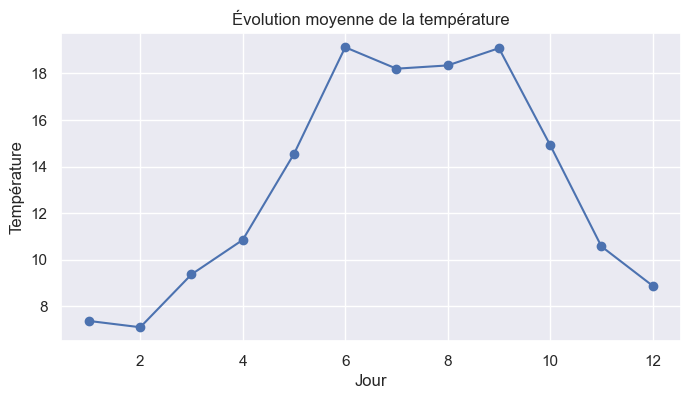

In [90]:
meteo_condition_lignes2 = meteo_selection_colonnes[meteo_selection_colonnes['annee'] == 2023]
meteo_condition_lignes2
temperature_moyenne_jour = meteo_condition_lignes2.groupby('mois')['Température (°C)'].mean().reset_index().round(2)
temperature_moyenne_jour


# dimension de la fenetre du graphique
plt.figure(figsize=(8, 4))

# graphique
plt.plot(temperature_moyenne_jour['mois'], temperature_moyenne_jour['Température (°C)'], marker='o', linestyle='-', color='b')

# titre
plt.title("Évolution moyenne de la température")

# noms des axes
plt.xlabel('Jour')
plt.ylabel('Température')

# afficher le graphique
plt.show()

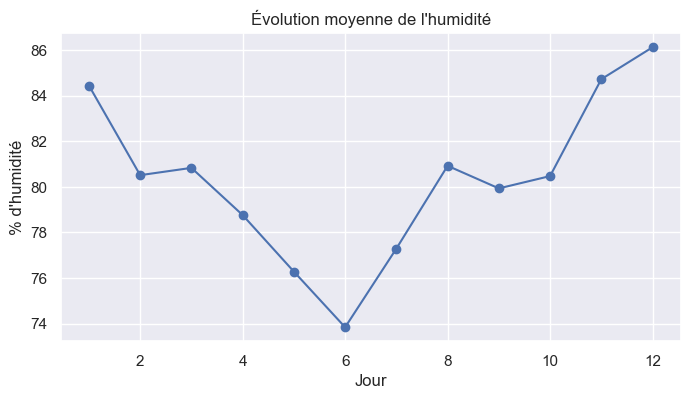

In [91]:
meteo_condition_lignes2 = meteo_selection_colonnes[meteo_selection_colonnes['annee'] == 2023]
meteo_condition_lignes2
temperature_moyenne_jour = meteo_condition_lignes2.groupby('mois')['Humidité'].mean().reset_index().round(2)
temperature_moyenne_jour


# dimension de la fenetre du graphique
plt.figure(figsize=(8, 4))

# graphique
plt.plot(temperature_moyenne_jour['mois'], temperature_moyenne_jour['Humidité'], marker='o', linestyle='-', color='b')

# titre
plt.title("Évolution moyenne de l'humidité")

# noms des axes
plt.xlabel('Jour')
plt.ylabel("% d'humidité")

# afficher le graphique
plt.show()

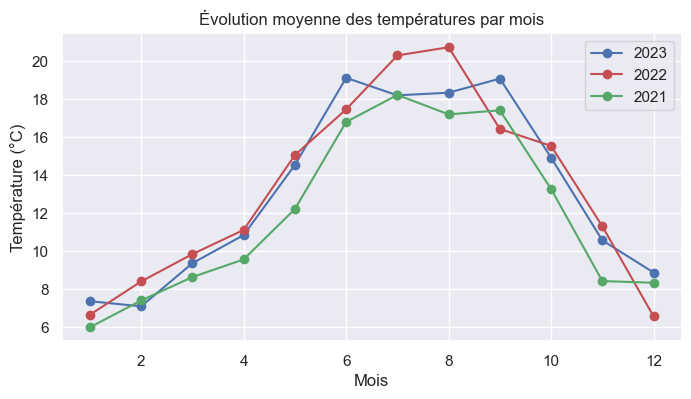

In [92]:
# Fonction pour calculer la température moyenne par jour pour une année donnée
def temperature_moyenne_par_annee(dataframe, annee):
    data_filtrée = dataframe[dataframe['annee'] == annee]
    return data_filtrée.groupby('mois')['Température (°C)'].mean().reset_index().round(2)

# Calcul des températures moyennes pour 2023, 2022 et 2021
temp_moy_2023 = temperature_moyenne_par_annee(meteo_selection_colonnes, 2023)
temp_moy_2022 = temperature_moyenne_par_annee(meteo_selection_colonnes, 2022)
temp_moy_2021 = temperature_moyenne_par_annee(meteo_selection_colonnes, 2021)

# Dimension de la fenêtre du graphique
plt.figure(figsize=(8, 4))

# Graphique pour chaque année
plt.plot(temp_moy_2023['mois'], temp_moy_2023['Température (°C)'], marker='o', linestyle='-', color='b', label='2023')
plt.plot(temp_moy_2022['mois'], temp_moy_2022['Température (°C)'], marker='o', linestyle='-', color='r', label='2022')
plt.plot(temp_moy_2021['mois'], temp_moy_2021['Température (°C)'], marker='o', linestyle='-', color='g', label='2021')

# Titre et noms des axes
plt.title('Évolution moyenne des températures par mois')
plt.xlabel('Mois')
plt.ylabel('Température (°C)')

# Légende
plt.legend()

# Afficher le graphique
plt.show()


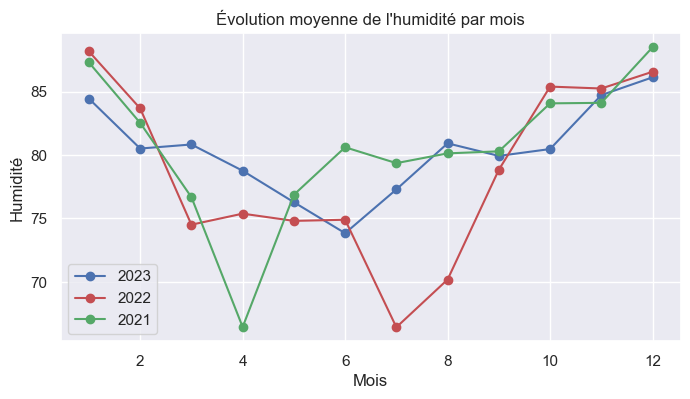

In [93]:
# Fonction pour calculer la température moyenne par jour pour une année donnée
def temperature_moyenne_par_annee(dataframe, annee):
    data_filtrée = dataframe[dataframe['annee'] == annee]
    return data_filtrée.groupby('mois')['Humidité'].mean().reset_index().round(2)

# Calcul des températures moyennes pour 2023, 2022 et 2021
temp_moy_2023 = temperature_moyenne_par_annee(meteo_selection_colonnes, 2023)
temp_moy_2022 = temperature_moyenne_par_annee(meteo_selection_colonnes, 2022)
temp_moy_2021 = temperature_moyenne_par_annee(meteo_selection_colonnes, 2021)

# Dimension de la fenêtre du graphique
plt.figure(figsize=(8, 4))

# Graphique pour chaque année
plt.plot(temp_moy_2023['mois'], temp_moy_2023['Humidité'], marker='o', linestyle='-', color='b', label='2023')
plt.plot(temp_moy_2022['mois'], temp_moy_2022['Humidité'], marker='o', linestyle='-', color='r', label='2022')
plt.plot(temp_moy_2021['mois'], temp_moy_2021['Humidité'], marker='o', linestyle='-', color='g', label='2021')

# Titre et noms des axes
plt.title("Évolution moyenne de l'humidité par mois")
plt.xlabel('Mois')
plt.ylabel('Humidité')

# Légende
plt.legend()

# Afficher le graphique
plt.show()


In [94]:
colonnes_resultat = ['Date','Température (°C)','Humidité','Etat du sol','Précipitations dans la dernière heure','Nom','annee','mois','jour','heure','department (code)','communes (name)','Nébulosité','Description Nébulosité','Pluie','Catégorie Pluie','Vent','Catégorie Vent','Longitude','Latitude','Altitude']

data_resultat = meteo[colonnes_resultat]

data_resultat

,Date,Température (°C),Humidité,Etat du sol,Précipitations dans la dernière heure,Nom,annee,mois,jour,heure,...,communes (name),Nébulosité,Description Nébulosité,Pluie,Catégorie Pluie,Vent,Catégorie Vent,Longitude,Latitude,Altitude
0,2021-01-08 13:00:00+01:00,2.1,85.0,0.0,0.0,ALENCON,2021,1,8,13,...,Cerisé,NaN,Non spécifié,0.00,Pluie Légère,15.742,Petite Brise,0.110167,48.445500,143
1,2021-01-09 04:00:00+01:00,-4.8,96.0,5.0,0.0,ALENCON,2021,1,9,4,...,Cerisé,NaN,Non spécifié,0.00,Pluie Légère,0.000,Calme,0.110167,48.445500,143
2,2021-01-05 10:00:00+01:00,2.1,90.0,1.0,0.0,ALENCON,2021,1,5,10,...,Cerisé,NaN,Non spécifié,0.00,Pluie Légère,22.224,Jolie brise,0.110167,48.445500,143
3,2021-05-26 20:00:00+02:00,11.9,83.0,1.0,0.0,ALENCON,2021,5,26,20,...,Cerisé,NaN,Non spécifié,3.05,Pluie Modérée,9.260,Légère brise,0.110167,48.445500,143
4,2021-05-14 17:00:00+02:00,13.3,69.0,0.0,0.0,ALENCON,2021,5,14,17,...,Cerisé,7.0,Ciel très nuageux à couvert,0.40,Pluie Légère,38.892,Vent frais,0.110167,48.445500,143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51096,2023-11-18 10:00:00+01:00,14.3,97.0,2.0,-0.1,RENNES-ST JACQUES,2023,11,18,10,...,Saint-Jacques-de-la-Lande,NaN,Non spécifié,1.10,Pluie Légère,54.634,Grand frais,-1.734000,48.068833,36
51097,2023-11-23 22:00:00+01:00,11.0,84.0,0.0,0.0,RENNES-ST JACQUES,2023,11,23,22,...,Saint-Jacques-de-la-Lande,NaN,Non spécifié,0.00,Pluie Légère,50.930,Grand frais,-1.734000,48.068833,36
51098,2023-12-06 04:00:00+01:00,2.2,97.0,0.0,0.0,RENNES-ST JACQUES,2023,12,6,4,...,Saint-Jacques-de-la-Lande,NaN,Non spécifié,0.00,Pluie Légère,13.890,Petite Brise,-1.734000,48.068833,36
51099,2023-12-13 04:00:00+01:00,7.9,96.0,NaN,0.0,RENNES-ST JACQUES,2023,12,13,4,...,Saint-Jacques-de-la-Lande,6.0,Ciel très nuageux,0.60,Pluie Légère,25.002,Jolie brise,-1.734000,48.068833,36


In [39]:
# Charger le deuxième jeu de données
df = pd.read_excel('Donnees intiales/frequentation_journaliere_2022-2023.xlsx')
 
# Calcul de la moyenne d'affluence pour chaque jour de la semaine
mean_affluence_per_day = df.groupby(df['Date '].dt.day_name())['Fréquentation gare'].mean().reset_index()
mean_affluence_per_day.columns = ['Jour', 'Moyenne_affluence']
 
# Fusionner le dataframe d'origine avec la moyenne d'affluence par jour
df = pd.merge(df, mean_affluence_per_day, left_on=df['Date '].dt.day_name(), right_on='Jour', how='left')
 
# Créer la colonne "Jour atypique" en comparant l'affluence avec la moyenne
df['Jour atypique'] = df['Fréquentation gare'] > df['Moyenne_affluence']
 
df.head(10)

,Nom de la gare,UIC,DRG,Date,Fréquentation gare,Jour,Moyenne_affluence,Jour atypique
0,Angers Saint-Laud,87484006,DRG B-CVL-PDL,2023-12-31,16754,Sunday,17175.385714,False
1,Guingamp,87473207,DRG B-CVL-PDL,2023-12-31,2274,Sunday,17175.385714,False
2,Nantes,87481002,DRG B-CVL-PDL,2023-12-31,34282,Sunday,17175.385714,True
3,Rennes,87471003,DRG B-CVL-PDL,2023-12-31,37472,Sunday,17175.385714,True
4,Saint-Brieuc,87473009,DRG B-CVL-PDL,2023-12-31,2167,Sunday,17175.385714,False
5,Vannes,87476606,DRG B-CVL-PDL,2023-12-31,3457,Sunday,17175.385714,False
6,Angers Saint-Laud,87484006,DRG B-CVL-PDL,2023-12-30,19781,Saturday,18366.146032,True
7,Guingamp,87473207,DRG B-CVL-PDL,2023-12-30,1680,Saturday,18366.146032,False
8,Nantes,87481002,DRG B-CVL-PDL,2023-12-30,46633,Saturday,18366.146032,True
9,Rennes,87471003,DRG B-CVL-PDL,2023-12-30,48441,Saturday,18366.146032,True


In [40]:
# Enregistrer le DataFrame dans un fichier CSV avec l'encodage UTF-8
data_resultat.to_csv('Donnees finales/sncf-meteo.csv', sep=";", index=False, encoding='utf-8')

NameError: name 'data_resultat' is not defined